In [53]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer
from massspecgym.tools.io import load_embeddings
from massspecgym.tools.data import get_embedding_for_node

import json
import os
from rdkit import Chem
from rdkit import RDLogger
import pandas as pd
import numpy as np
from collections import defaultdict, deque
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE
from matplotlib.colors import Normalize
from matplotlib import cm


In [2]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [3]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1,
            'bin_width': 1.0,
        },
    },
}

featurizer = SpectrumFeaturizer(config, mode='torch')

In [4]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [5]:
all_smiles = msn_dataset.smiles

In [6]:
len(all_smiles)

16476

In [9]:
tree_one = msn_dataset.trees[0]

In [11]:
tree_one 

347.14891
  329.139404296875
    175.075592041016
    160.051956176758
  193.086303710938
    151.075317382813
    107.049133300781
  175.076354980469
  155.070388793945
    112.051902770996
    95.049163818359
  151.075546264648
    135.044143676758
    107.049140930176

In [15]:
tree_one.root.children[329.139404296875]

329.139404296875
  175.075592041016
  160.051956176758

In [24]:
tree_one.root.children[329.139404296875].spectrum.get(('msn_precursor_mzs'))

'[347.149261474609, 329.139404296875]'

In [26]:

unique_smiles = list(set(all_smiles))
print(f"Unique SMILES entries: {len(unique_smiles)}")

Unique SMILES entries: 13984


In [27]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

## Compare with JSON

In [28]:
# Suppress RDKit warnings for cleaner output
RDLogger.DisableLog('rdApp.*')

def canonicalize_smiles(smiles):
    """
    Canonicalize a SMILES string using RDKit.
    
    Parameters:
        smiles (str): The SMILES string to canonicalize.
    
    Returns:
        str or None: The canonical SMILES string, or None if invalid.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
        else:
            return None
    except:
        return None

def load_json_unique_smiles(json_path):
    """
    Load JSON data and create a mapping of canonical SMILES to their records.
    Keeps only the first occurrence of each canonical SMILES.
    
    Parameters:
        json_path (str): Path to the JSON file.
    
    Returns:
        dict: Mapping of canonical SMILES to JSON records.
    """
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"JSON file not found at path: {json_path}")
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    canonical_smiles_map = {}
    for record in data:
        smi = record.get('smiles', '').strip()
        canonical = canonicalize_smiles(smi)
        if canonical and canonical not in canonical_smiles_map:
            canonical_smiles_map[canonical] = record
    return canonical_smiles_map

def load_unique_smiles(smiles_list):
    """
    Extract unique SMILES from the dataset and canonicalize them.
    
    Parameters:
        smiles_list (list of smiles): Your dataset containing a 'smiles' column.
    
    Returns:
        dict: Mapping of original SMILES to their canonical forms.
    """

    canonical_map = {}
    for smi in smiles_list:
        canonical = canonicalize_smiles(smi)
        canonical_map[smi] = canonical
    return canonical_map

# def match_smiles(canonical_msn_map, json_canonical_map):
#     """
#     Match canonical SMILES from the dataset to those in the JSON data.
#     
#     Parameters:
#         canonical_msn_map (dict): Mapping of original SMILES to canonical SMILES from the dataset.
#         json_canonical_map (dict): Mapping of canonical SMILES to JSON records.
#     
#     Returns:
#         tuple: (matched_records, unmatched_smiles, match_count, unmatch_count, invalid_count)
#     """
#     matched = {}
#     unmatched = []
#     match_count = 0
#     unmatch_count = 0
#     invalid_count = 0
#     
#     for original_smi, canonical_smi in canonical_msn_map.items():
#         if canonical_smi is None:
#             invalid_count += 1
#             unmatched.append(original_smi)
#             continue
#         if canonical_smi in json_canonical_map:
#             matched[original_smi] = json_canonical_map[canonical_smi]
#             match_count += 1
#         else:
#             unmatched.append(original_smi)
#             unmatch_count += 1
#     return matched, unmatched, match_count, unmatch_count, invalid_count


def get_ms_level(node) -> Optional[int]:
    """
    Return the ms_level from node's spectrum metadata if present.
    """
    if node is None or node.spectrum is None:
        return None
    ms_level_str = node.spectrum.get('ms_level')
    if ms_level_str is not None:
        return int(ms_level_str)
    return None


def gather_nodes_by_level_in_tree(tree) -> Dict[int, List]:
    """
    Gather all nodes from 'tree' grouped by their ms_level.
    Returns a dictionary: { ms_level (int) -> list of TreeNodes }.
    """
    nodes_by_level = defaultdict(list)

    # BFS to traverse the tree
    queue = deque([tree.root])
    while queue:
        node = queue.popleft()
        # Get ms_level from node
        lvl = get_ms_level(node)
        if lvl is not None:
            nodes_by_level[lvl].append(node)

        # Enqueue children
        for child in node.children.values():
            queue.append(child)

    return dict(nodes_by_level)  # Convert defaultdict -> normal dict

# Function to perform sampling
def sample_per_level(df: pd.DataFrame, max_samples: int) -> pd.DataFrame:
    """
    Randomly sample up to max_samples from each MS level.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with 'embedding' and 'ms_level' columns.
        max_samples (int): Maximum number of samples per MS level.
        
    Returns:
        pd.DataFrame: Sampled DataFrame.
    """
    # Group by 'ms_level'
    grouped = df.groupby('ms_level')
    
    # Apply sampling to each group
    sampled_df = grouped.apply(lambda x: x.sample(n=min(len(x), max_samples), random_state=42))
    
    # Remove the extra index introduced by groupby
    sampled_df.reset_index(drop=True, inplace=True)
    
    return sampled_df

# def extract_tree_id(node_id):
#     """
#     Extracts the tree identifier from the node identifier.
#     Assumes the first seven characters represent the tree_id.
#     
#     Parameters:
#         node_id (str): The node identifier (e.g., '0006494_0000004').
#         
#     Returns:
#         str: The extracted tree_id (e.g., '0006494').
#     """
#     return node_id.split('_')[0] if '_' in node_id else node_id[:7]

def create_classyfire_df(json_path):
    """
    Create a pandas DataFrame from the ClassyFire JSON results.
    
    Parameters:
        json_path (str): Path to the JSON classification results.
    
    Returns:
        pd.DataFrame: DataFrame with columns ['smiles', 'canonical_smiles', 'class', 'subclass', 'kingdom', 'superclass'].
    """
    # Load the JSON data
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    # Initialize a list to store processed records
    processed_records = []
    
    # Iterate through each record in the JSON data
    for record in data:
        # Extract the original SMILES
        smiles = record.get('smiles', None)
        
        # Canonicalize the SMILES
        canonical_smiles = canonicalize_smiles(smiles) 
        
        # Extract classification fields safely
        classification = {}
        for field in ['kingdom', 'superclass', 'class', 'subclass']:
            field_data = record.get(field, {})
            classification[field] = field_data.get('name') if isinstance(field_data, dict) else None
        
        # Create a dictionary for the current record
        processed_record = {
            'smiles': smiles,
            'canonical_smiles': canonical_smiles,
            'kingdom': classification['kingdom'],
            'superclass': classification['superclass'],
            'class': classification['class'],
            'subclass': classification['subclass']
        }
        
        # Append the processed record to the list
        processed_records.append(processed_record)
    
    # Create a pandas DataFrame from the list of processed records
    classyfire_df = pd.DataFrame(processed_records)
    
    return classyfire_df

def analyze_classyfire_df(classyfire_df, canonical_msn_map):
    """
    Analyze the ClassyFire DataFrame to determine matched and unmatched SMILES,
    ensure consistency among duplicate SMILES, and print statistics.

    Parameters:
        classyfire_df (pd.DataFrame): DataFrame with columns ['smiles', 'canonical_smiles', 'class', 'subclass', 'kingdom', 'superclass'].
        canonical_msn_map (dict): Mapping of original SMILES to their canonical forms.

    Returns:
        pd.DataFrame: Reduced DataFrame with unique canonical SMILES and their attributes.
    """
    # Step 1: Calculate Matching Statistics
    total_unique = len(canonical_msn_map)
    match_count = 0
    unmatch_count = 0
    invalid_count = 0

    json_canonical_set = set(classyfire_df['canonical_smiles'].dropna().unique())

    for original_smi, canonical_smi in canonical_msn_map.items():
        if canonical_smi is None:
            invalid_count += 1
        elif canonical_smi in json_canonical_set:
            match_count += 1
        else:
            unmatch_count += 1

    # Print Matching Statistics
    print("\n=== Matching Results ===")
    print(f"Total unique SMILES in your dataset: {total_unique}")
    print(f"Matched SMILES: {match_count}")
    print(f"Unmatched SMILES: {unmatch_count}")
    print(f"Invalid SMILES: {invalid_count}")

    # Step 2: Reduce the DataFrame to unique canonical_smiles
    # Keep only matched SMILES
    matched_df = classyfire_df[classyfire_df['canonical_smiles'].isin(json_canonical_set)].copy()

    # Drop duplicates based on canonical_smiles, keeping the first occurrence
    unique_classyfire_df = matched_df.drop_duplicates(subset=['canonical_smiles']).copy()

    # Step 3: Verify Consistency Among Duplicate SMILES
    # Identify duplicate SMILES in classyfire_df
    duplicates = classyfire_df[classyfire_df.duplicated(subset=['smiles'], keep=False)]

    inconsistent = []

    # Group by 'smiles' and check for consistency
    for smi, group in duplicates.groupby('smiles'):
        # Check if all attributes are the same within the group
        attributes = group[['canonical_smiles', 'class', 'subclass', 'kingdom', 'superclass']]
        if attributes.nunique().max() > 1:
            inconsistent.append(smi)

    # Print Consistency Results
    if inconsistent:
        print(f"\nNumber of SMILES with inconsistent attributes: {len(inconsistent)}")
        print("Example of inconsistent SMILES with differing attributes:")
        example_smi = inconsistent[0]
        example_group = duplicates[duplicates['smiles'] == example_smi]
        print(example_group)
    else:
        print("\nAll duplicate SMILES have consistent attributes.")

    # Step 4: Comprehensive Statistics
    print("\n=== Comprehensive Statistics ===")
    print(f"Total unique canonical SMILES: {unique_classyfire_df['canonical_smiles'].nunique()}")
    print(f"Total unique SMILES: {classyfire_df['smiles'].nunique()}")

    # Step 5: Return the Reduced DataFrame
    return unique_classyfire_df
def print_unique_counts(df, classification_level):
    """
    Print the number of unique values for a given classification level.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        classification_level (str): One of ['kingdom', 'superclass', 'class', 'subclass'].

    Returns:
        None
    """
    if classification_level not in ['kingdom', 'superclass', 'class', 'subclass']:
        print(f"Invalid classification level: {classification_level}")
        return
    
    unique_count = df[classification_level].nunique()
    print(f"Total unique values for '{classification_level}': {unique_count}")
    

def plot_class_distribution(df, classification_level, top_n=50, output_svg=False):
    """
    Plot the distribution of a classification level across different folds.

    Parameters:
        df (pd.DataFrame): Merged DataFrame containing classification and fold information.
        classification_level (str): One of ['kingdom', 'superclass', 'class', 'subclass'].
        top_n (int): Number of top classes to display individually; others are grouped as 'Other'.
        output_svg (bool): Whether to save the histogram as an SVG file.

    Returns:
        None
    """
    if classification_level not in ['kingdom', 'superclass', 'class', 'subclass']:
        print(f"Invalid classification level: {classification_level}")
        return

    # Calculate value counts
    cls_vc = df[classification_level].value_counts()

    # Select top_n classes
    top_classes = cls_vc.head(top_n).index

    # Replace classes not in top_n with 'Other'
    df_top = df.copy()
    df_top.loc[~df_top[classification_level].isin(top_classes), classification_level] = f'Other ({df_top[classification_level].nunique() - top_n} classes)'

    # Sort the DataFrame based on the frequency of classes
    df_top = df_top.sort_values(classification_level, key=lambda x: -x.map(cls_vc))

    # Replace 'fold' values with more readable labels
    df_top['Fold'] = df_top['fold'].replace({'train': 'Training', 'val': 'Validation', 'test': 'Testing'})

    # Define the desired reverse order for the folds (Testing first, Validation, Training)
    reverse_fold_order = ['Training', 'Validation', 'Testing']

    # Convert 'Fold' to a categorical type with the specified order
    df_top['Fold'] = pd.Categorical(df_top['Fold'], categories=reverse_fold_order, ordered=True)

    # Rename columns for clarity
    df_top = df_top.rename(columns={classification_level: 'Chemical class'})

    # Debug: Print value counts
    print(f"\nValue counts for {classification_level}:")
    print(df_top['Chemical class'].value_counts().head(top_n))

    # Define a color palette (Set2 for better contrast)
    palette = sns.color_palette('Set2', n_colors=len(reverse_fold_order))
    fold_palette = dict(zip(reverse_fold_order, palette))

    # Initialize plotting
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 10))

    # Create the histogram
    sns.histplot(
        data=df_top,
        y='Chemical class',
        hue='Fold',
        multiple='stack',
        shrink=1,
        palette=fold_palette,  # Use the defined palette
        edgecolor='none',
        hue_order=reverse_fold_order  # Reverse the hue order
    )

    # Set plot labels and title
    plt.xlabel('Number of Unique Molecules')
    plt.ylabel('Chemical Class')
    plt.title(f'Distribution of {classification_level.capitalize()} Across Folds')

    # Custom legend creation
    custom_legend = [
        plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10, label=fold)
        for fold, color in fold_palette.items()
    ]

    plt.legend(handles=custom_legend, title='Fold', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Improve layout to prevent clipping of labels and legend
    plt.tight_layout()

    # Save and show the plot
    if output_svg:
        plt.savefig(f'{classification_level}_classes_hist.svg')
    plt.show()

def analyze_exclusive_classes(df, classification_level):
    """
    Identify and print exclusive classes and molecule counts per fold for a given classification level.

    Parameters:
        df (pd.DataFrame): Merged DataFrame containing classification and fold information.
        classification_level (str): One of ['kingdom', 'superclass', 'class', 'subclass'].

    Returns:
        None
    """
    if classification_level not in ['kingdom', 'superclass', 'class', 'subclass']:
        print(f"Invalid classification level: {classification_level}")
        return

    # Group by classification and fold
    df_cls_folds = df.groupby([classification_level, 'fold'])['mol_freq'].count().sort_values(ascending=False)
    df_cls_folds = df_cls_folds.unstack().fillna(0).astype(int)

    # Ensure the folds are in the desired order
    if set(['train', 'val', 'test']).issubset(df_cls_folds.columns):
        df_cls_folds = df_cls_folds[['train', 'val', 'test']]
    else:
        # Adjust based on available folds
        available_folds = [fold for fold in ['train', 'val', 'test'] if fold in df_cls_folds.columns]
        df_cls_folds = df_cls_folds[available_folds]

    # Sort based on 'train' count
    if 'train' in df_cls_folds.columns:
        df_cls_folds = df_cls_folds.sort_values('train', ascending=False)
    elif 'val' in df_cls_folds.columns:
        df_cls_folds = df_cls_folds.sort_values('val', ascending=False)
    elif 'test' in df_cls_folds.columns:
        df_cls_folds = df_cls_folds.sort_values('test', ascending=False)

    # Print exclusive classes and molecule counts per fold
    folds = ['train', 'val', 'test']
    print(f"\n=== Exclusive Classes for {classification_level.capitalize()} ===")
    for f in folds:
        if f not in df_cls_folds.columns:
            continue  # Skip if fold is not present
        print('---', f.capitalize(), '---')
        folds_other = [x for x in folds if x != f]
        if not folds_other:
            print(f"No other folds to compare with for fold '{f}'.")
            continue
        # Create a mask where other folds have zero
        mask = (df_cls_folds[folds_other[0]] == 0)
        if len(folds_other) > 1:
            for other_fold in folds_other[1:]:
                mask &= (df_cls_folds[other_fold] == 0)
        df_only_f = df_cls_folds[mask]
        print('Num. exclusive classes:', len(df_only_f))
        print('Num. exclusive molecules:', df_only_f[f].sum())

In [157]:
# Define the path to your JSON classification results
json_path = '/Users/macbook/CODE/PyClassyFire/data/final_classification_results.json'

# Create the DataFrame
classyfire_df = create_classyfire_df(json_path)

In [158]:
classyfire_df["canonical_smiles"].nunique()

13958

In [159]:
canonical_msn_map = load_unique_smiles(all_smiles)
total_unique = len(canonical_msn_map)
print(f"Total unique SMILES in your dataset: {total_unique}")

Total unique SMILES in your dataset: 13984


In [160]:
# Analyze the ClassyFire DataFrame
unique_classyfire_df = analyze_classyfire_df(classyfire_df, canonical_msn_map)


=== Matching Results ===
Total unique SMILES in your dataset: 13984
Matched SMILES: 13407
Unmatched SMILES: 577
Invalid SMILES: 0

All duplicate SMILES have consistent attributes.

=== Comprehensive Statistics ===
Total unique canonical SMILES: 13958
Total unique SMILES: 13958


In [161]:
unique_classyfire_df.keys()

Index(['smiles', 'canonical_smiles', 'kingdom', 'superclass', 'class',
       'subclass'],
      dtype='object')

In [162]:
# Assuming 'msn_dataset.metadata' is your main DataFrame
root_nodes = msn_dataset.metadata[msn_dataset.metadata["ms_level"] == "2"].copy()

print(f"Total root nodes: {len(root_nodes)}")

Total root nodes: 16476


In [164]:
# Add 'canonical_smiles' to root_nodes DataFrame
root_nodes['canonical_smiles'] = root_nodes['smiles'].apply(canonicalize_smiles)

In [165]:
root_nodes['canonical_smiles'].nunique()

13984

In [169]:
# Calculate the number of overlapping canonical SMILES
overlap = root_nodes['canonical_smiles'].isin(unique_classyfire_df['canonical_smiles'])
print(f"Number of overlapping canonical SMILES: {overlap.sum()} out of {len(root_nodes)}")

Number of overlapping canonical SMILES: 15801 out of 16476


In [170]:
merged_df = pd.merge(root_nodes, unique_classyfire_df, on='canonical_smiles', how='inner')

In [172]:
len(merged_df)

15801

In [178]:
# Perform analysis for each classification level
classification_levels = ['kingdom', 'superclass', 'class', 'subclass']

for classification in classification_levels:
    print(f"\n===== Analysis for {classification.capitalize()} =====")
    print_unique_counts(merged_df, classification)



===== Analysis for Kingdom =====
Total unique values for 'kingdom': 1

===== Analysis for Superclass =====
Total unique values for 'superclass': 16

===== Analysis for Class =====
Total unique values for 'class': 253

===== Analysis for Subclass =====
Total unique values for 'subclass': 388



Value counts for kingdom:
Chemical class
Organic compounds    15801
Name: count, dtype: int64


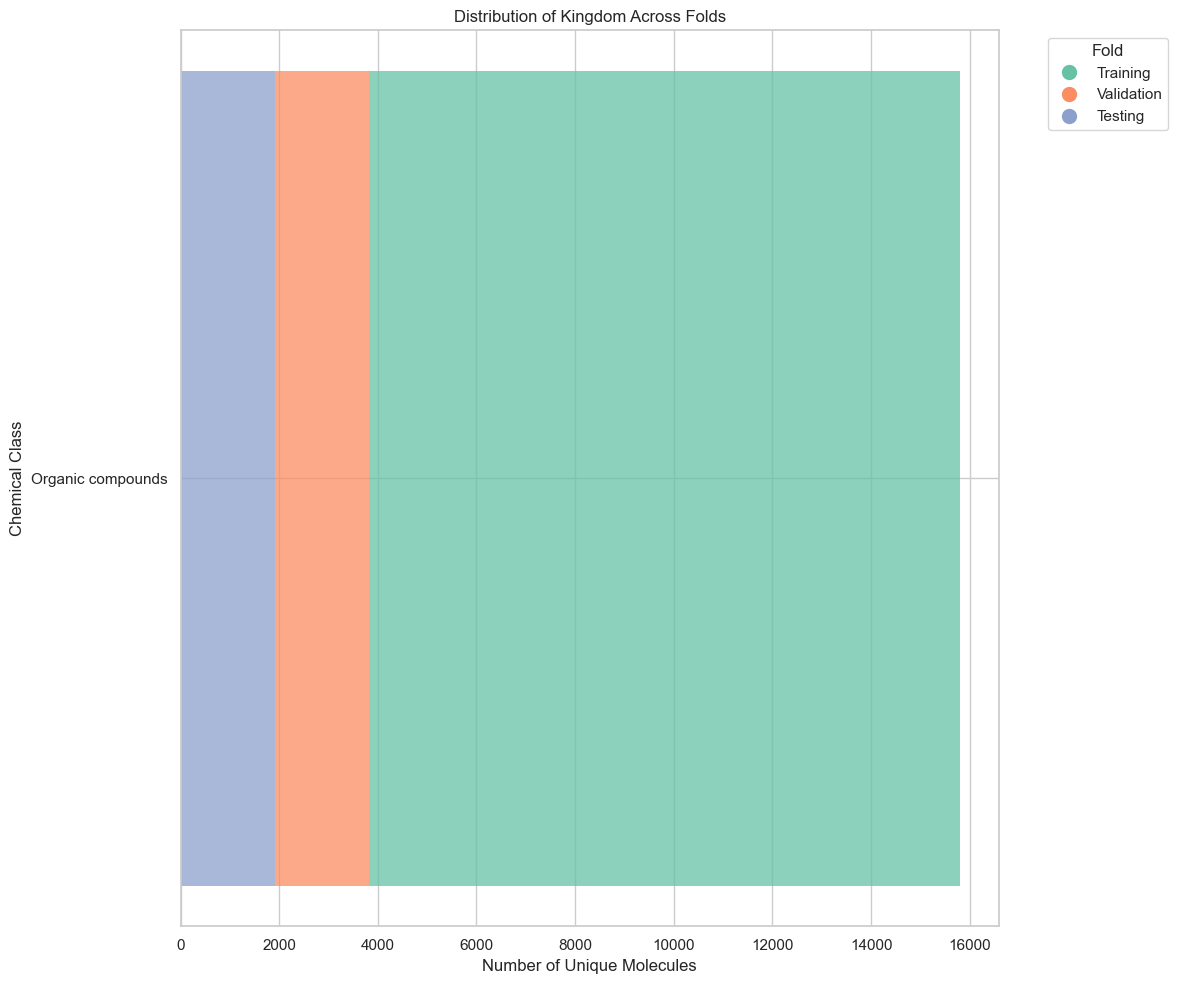

In [207]:
plot_class_distribution(merged_df, 'kingdom', top_n=50, output_svg=False)


Value counts for superclass:
Chemical class
Organoheterocyclic compounds                 6203
Benzenoids                                   3200
Organic acids and derivatives                1822
Lipids and lipid-like molecules              1681
Phenylpropanoids and polyketides             1389
Organic oxygen compounds                      643
Organic nitrogen compounds                    270
Alkaloids and derivatives                     221
Organosulfur compounds                        131
Nucleosides, nucleotides, and analogues       127
Lignans, neolignans and related compounds     102
Hydrocarbon derivatives                         3
Organohalogen compounds                         3
Organic 1,3-dipolar compounds                   2
Organic Polymers                                2
Organophosphorus compounds                      2
Name: count, dtype: int64


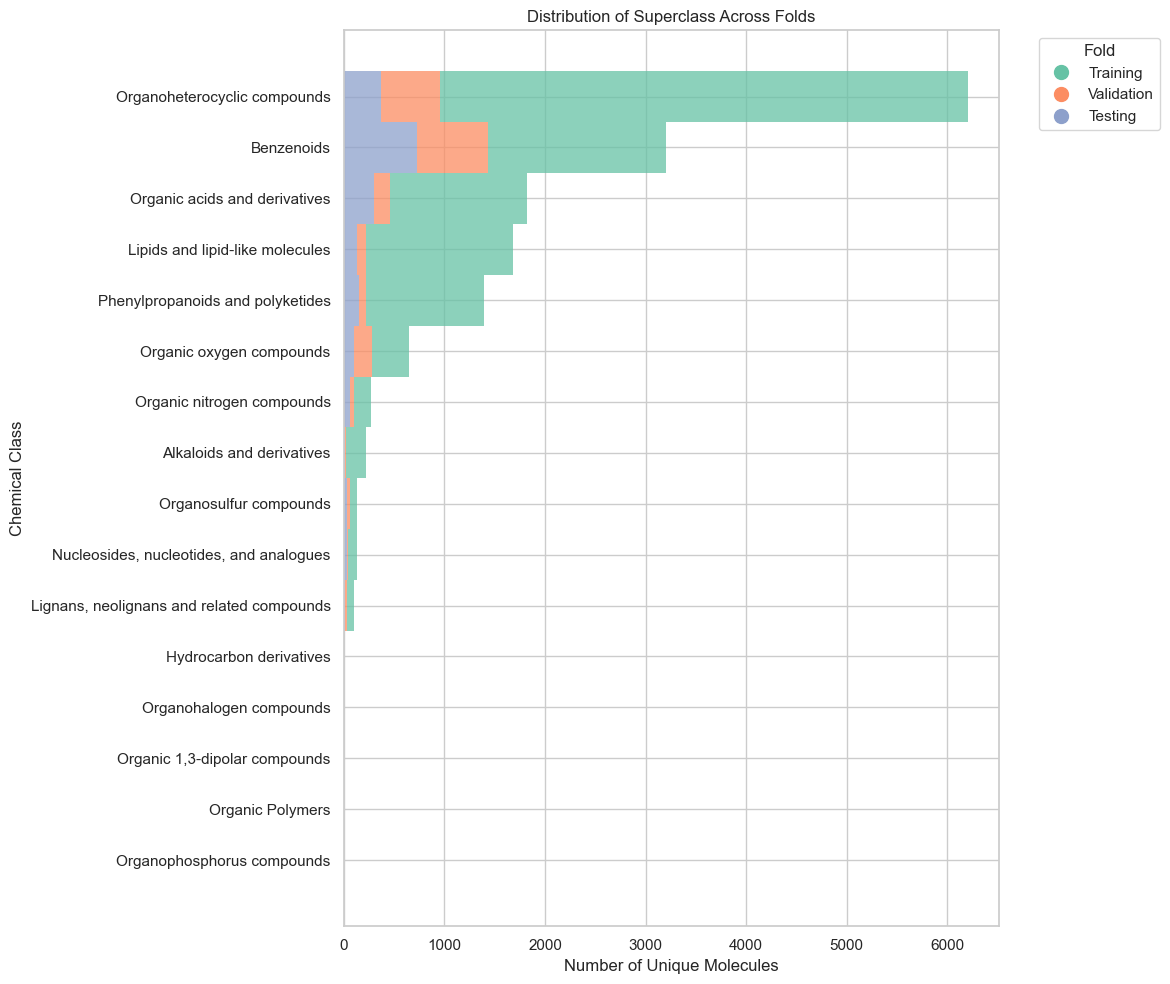

In [208]:
plot_class_distribution(merged_df, 'superclass', top_n=50, output_svg=False)


Value counts for class:
Chemical class
Benzene and substituted derivatives    2583
Other (203 classes)                    1775
Carboxylic acids and derivatives       1653
Prenol lipids                           958
Organooxygen compounds                  643
Azoles                                  636
Indoles and derivatives                 544
Quinolines and derivatives              500
Pyridines and derivatives               492
Diazinanes                              457
Flavonoids                              418
Steroids and steroid derivatives        395
Diazanaphthalenes                       346
Piperidines                             321
Diazines                                320
Organonitrogen compounds                270
Coumarins and derivatives               259
Fatty Acyls                             252
Benzopyrans                             211
Phenol ethers                           203
Benzimidazoles                          202
Naphthalenes                        

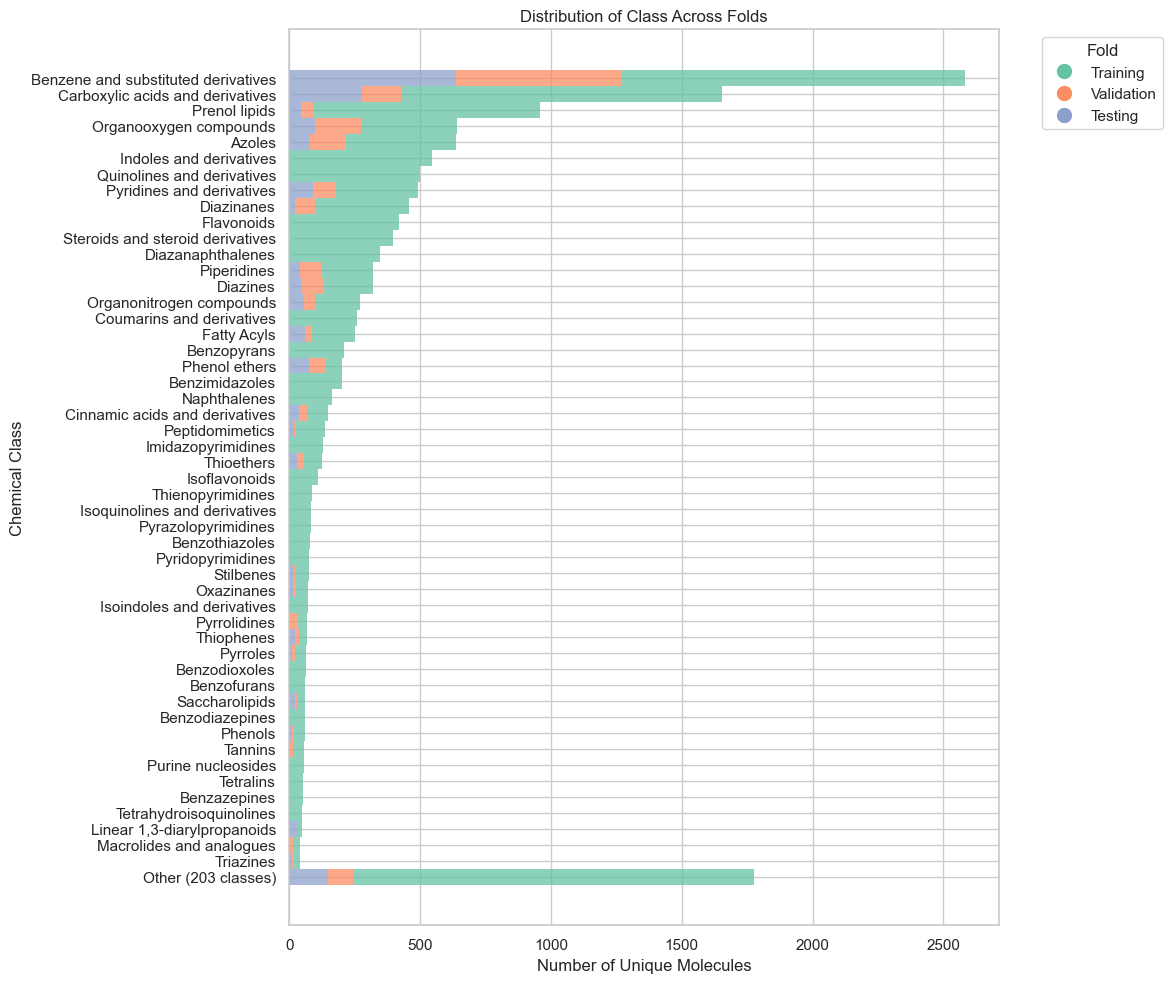

In [209]:
plot_class_distribution(merged_df, 'class', top_n=50, output_svg=False)


Value counts for subclass:
Chemical class
Other (338 classes)                          6857
Amino acids, peptides, and analogues         1494
Benzoic acids and derivatives                 500
Piperazines                                   456
Anilides                                      455
Terpene glycosides                            450
Benzodiazines                                 310
Carbohydrates and carbohydrate conjugates     286
Flavonoid glycosides                          254
Pyrimidines and pyrimidine derivatives        231
Pyrazoles                                     219
1-benzopyrans                                 206
Amines                                        201
Benzenesulfonamides                           199
Carbonyl compounds                            186
Indoles                                       167
Diphenylmethanes                              152
Diterpenoids                                  147
Terpene lactones                              134
Ethers 

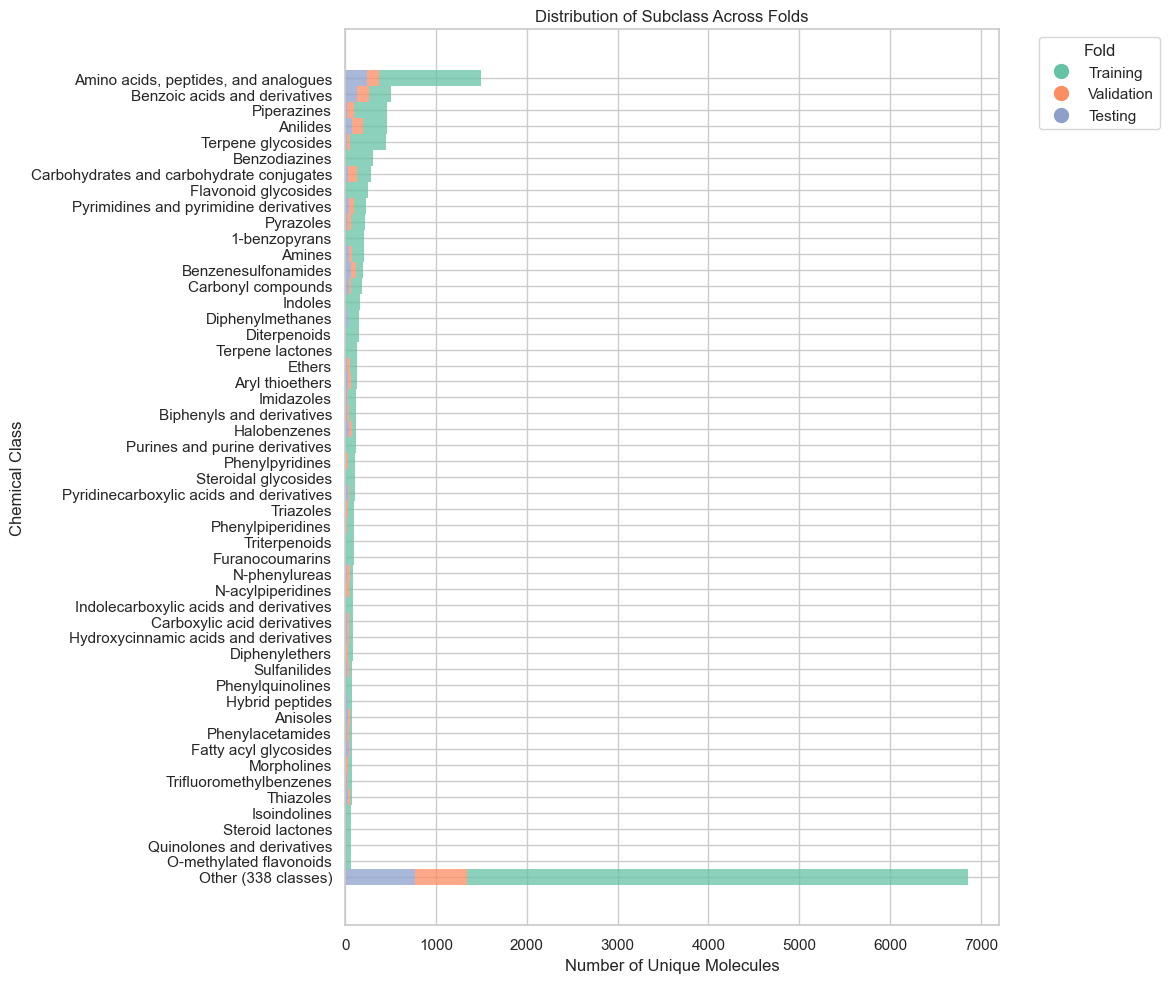

In [210]:
plot_class_distribution(merged_df, 'subclass', top_n=50, output_svg=False)

In [211]:
for classification in classification_levels:
    print(f"\n===== Analysis for {classification.capitalize()} =====")
    analyze_exclusive_classes(merged_df, classification)


===== Analysis for Kingdom =====

=== Exclusive Classes for Kingdom ===
--- Train ---
Num. exclusive classes: 0
Num. exclusive molecules: 0
--- Val ---
Num. exclusive classes: 0
Num. exclusive molecules: 0
--- Test ---
Num. exclusive classes: 0
Num. exclusive molecules: 0

===== Analysis for Superclass =====

=== Exclusive Classes for Superclass ===
--- Train ---
Num. exclusive classes: 3
Num. exclusive molecules: 7
--- Val ---
Num. exclusive classes: 0
Num. exclusive molecules: 0
--- Test ---
Num. exclusive classes: 1
Num. exclusive molecules: 2

===== Analysis for Class =====

=== Exclusive Classes for Class ===
--- Train ---
Num. exclusive classes: 178
Num. exclusive molecules: 3874
--- Val ---
Num. exclusive classes: 2
Num. exclusive molecules: 2
--- Test ---
Num. exclusive classes: 7
Num. exclusive molecules: 11

===== Analysis for Subclass =====

=== Exclusive Classes for Subclass ===
--- Train ---
Num. exclusive classes: 218
Num. exclusive molecules: 3234
--- Val ---
Num. exclu

In [29]:
# For each tree in 'msn_dataset', gather nodes grouped by ms_level
dataset_levels_dict = {}

for tree in msn_dataset.trees:
    # Identify tree by the root's identifier
    root_id = "no_id"
    if tree.root and tree.root.spectrum:
        root_id = tree.root.spectrum.get('identifier')

    # Gather nodes by level
    nodes_by_level = gather_nodes_by_level_in_tree(tree)
    dataset_levels_dict[root_id] = nodes_by_level

In [70]:
# Initialize lists to store embeddings, MS levels, node identifiers, tree_ids, precursor_mz, and num_peaks
embeddings_list = []
ms_levels_list = []
node_ids_list = []
tree_ids_list = []
precursor_mz_list = []
num_peaks_list = []

# Iterate over each tree in the dataset
for tree_id, levels_dict in dataset_levels_dict.items():
    for level, nodes in levels_dict.items():
        ms_level = int(level) 
        for node in nodes:
            embedding = get_embedding_for_node(node, embeddings_dict)
            if embedding is not None:
                embeddings_list.append(embedding)
                ms_levels_list.append(ms_level)
                node_id = node.spectrum.get('identifier')
                node_ids_list.append(node_id)
                tree_ids_list.append(tree_id)
                
                # Retrieve precursor_mz from node.value
                precursor_mz = node.value if hasattr(node, 'value') else None
                precursor_mz_list.append(precursor_mz)
                
                # Retrieve num_peaks from node.num_peaks
                num_peaks = int(node.spectrum.get('num_peaks'))
                num_peaks_list.append(num_peaks)

# Create a DataFrame with the extended structure
data = pd.DataFrame({
    'node_id': node_ids_list,
    'embedding': embeddings_list,
    'ms_level': ms_levels_list,
    'tree_id': tree_ids_list,
    'precursor_mz': precursor_mz_list,
    'num_peaks': num_peaks_list
})

print(f"Total nodes with embeddings: {len(data)}")
print("DataFrame Preview:")
display(data.head())

Total nodes with embeddings: 183284
DataFrame Preview:


node_id                                          embedding  \
0  0000002_0000000  [0.4537652, -0.3069397, -0.35244426, -0.125019...   
1  0000008_0000001  [0.2054497, -0.39231035, 1.3239981, 0.2575079,...   
2  0000008_0000010  [0.4743055, -0.110510744, -0.23743646, -1.3675...   
3  0000008_0000028  [0.56264716, -0.4539912, 0.15218258, 0.3159927...   
4  0000008_0000030  [-1.3280908, -0.7864733, 1.0920051, 0.62619793...   

   ms_level          tree_id  precursor_mz  num_peaks  
0         2  0000002_0000000    347.148910         38  
1         3  0000002_0000000    329.139404          5  
2         3  0000002_0000000    193.086304         65  
3         3  0000002_0000000    175.076355          3  
4         3  0000002_0000000    155.070389         47

In [65]:
def plot_attribute_distribution(df, ms_level, attribute, output_svg=False):
    """
    Plot the distribution of a specified attribute for a given ms_level.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the attribute and 'ms_level'.
        ms_level (int): The ms_level to filter the data.
        attribute (str): The attribute to plot (e.g., 'precursor_mz' or 'num_peaks').
        output_svg (bool): Whether to save the plot as an SVG file.
    
    Returns:
        None
    """
    # Validate attribute
    if attribute not in df.columns:
        print(f"Attribute '{attribute}' not found in the DataFrame.")
        return
    
    # Filter the DataFrame for the specified ms_level
    df_level = df[df['ms_level'] == ms_level]
    
    # Check if there are data points for the specified ms_level
    if df_level.empty:
        print(f"No data available for ms_level {ms_level}.")
        return
    
    plt.figure(figsize=(8, 6))
    
    # Determine if the attribute is continuous or discrete
    if pd.api.types.is_numeric_dtype(df_level[attribute]):
        # Plot histogram with KDE
        sns.histplot(df_level[attribute].dropna(), kde=True, bins=50, color='skyblue')
        plt.xlabel(attribute.replace('_', ' ').capitalize())
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {attribute.replace("_", " ").capitalize()} for MS Level {ms_level}')
    else:
        # Plot countplot for categorical data
        sns.countplot(data=df_level, x=attribute, palette='viridis')
        plt.xlabel(attribute.replace('_', ' ').capitalize())
        plt.ylabel('Count')
        plt.title(f'Count of {attribute.replace("_", " ").capitalize()} for MS Level {ms_level}')
    
    # Save the plot
    if output_svg:
        plt.savefig(f'{attribute}_distribution_ms_level_{ms_level}.svg')
    
    plt.show()

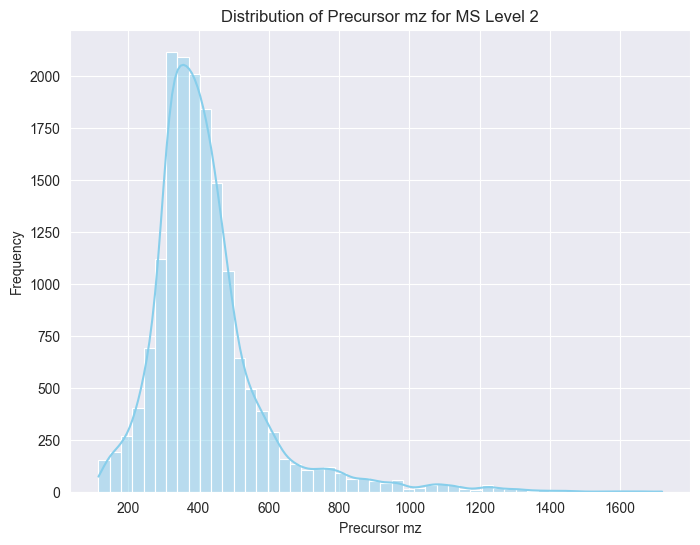

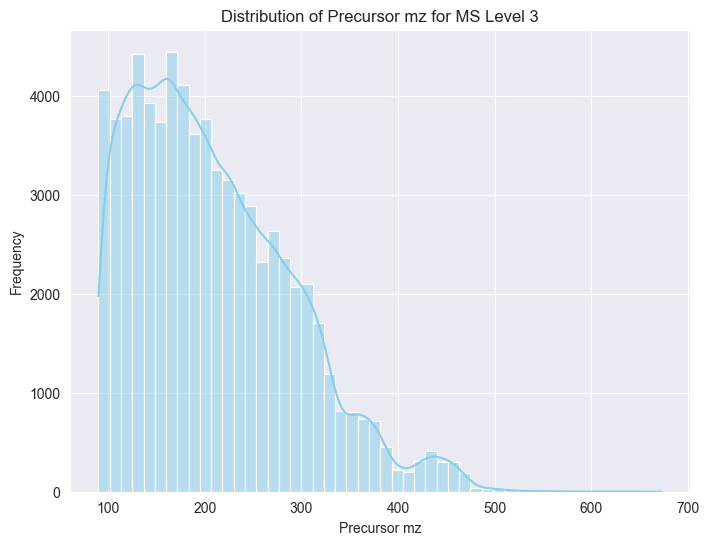

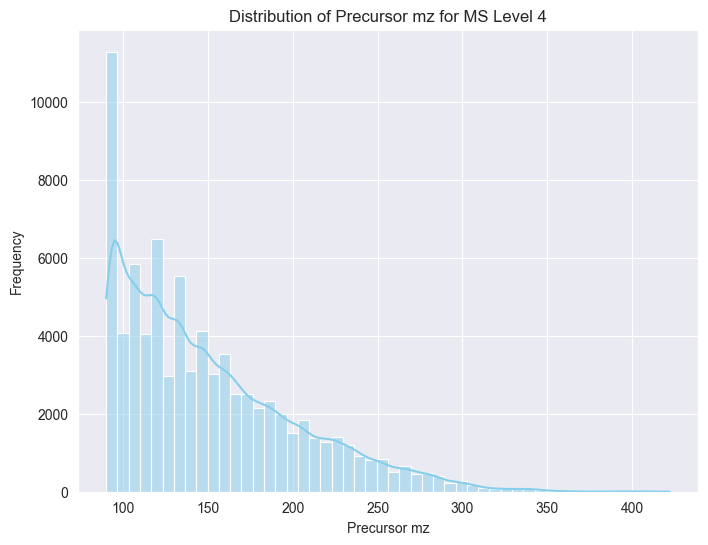

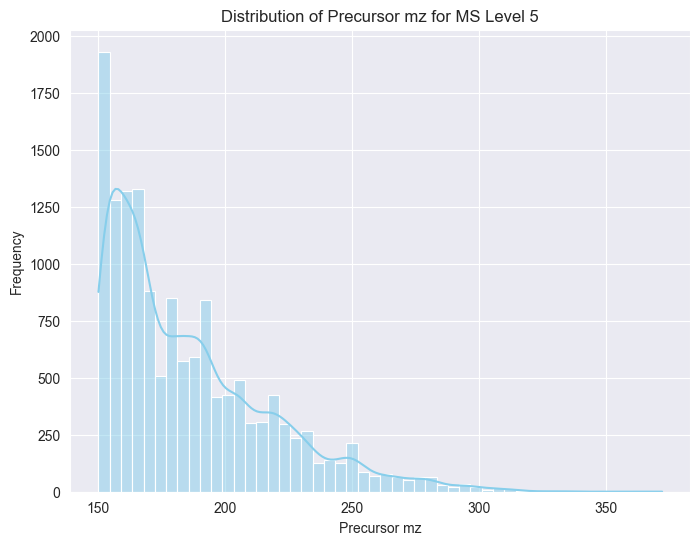

In [66]:
for level_i in data['ms_level'].unique():
    plot_attribute_distribution(data, ms_level=level_i, attribute='precursor_mz', output_svg=False)

In [62]:
def plot_attribute_overlay(df, attribute, output_svg=False):
    """
    Plot overlay distributions of precursor_mz across all ms_levels.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'precursor_mz' and 'ms_level'.
        attribute (str): The attribute to plot (e.g., 'precursor_mz' or 'num_peaks').
        output_svg (bool): Whether to save the plot as an SVG file.
    
    Returns:
        None
    """

    if attribute not in df.columns:
        print(f"Attribute '{attribute}' not found in the DataFrame.")
        return
    
    # Remove rows with NaN precursor_mz
    df_clean = df
    
    # Check if there are data points
    if df_clean.empty:
        print("No data available for plotting precursor_mz distributions.")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Define a contrastive color palette
    ms_levels = df_clean['ms_level'].unique()
    palette = sns.color_palette("tab10", len(ms_levels))
    level_colors = dict(zip(ms_levels, palette))
    
    # Plot KDE for each ms_level
    for level, color in level_colors.items():
        sns.kdeplot(
            data=df_clean[df_clean['ms_level'] == level],
            x=attribute,
            fill=True,
            alpha=0.6,
            label=f'MS Level {level}',
            color=color
        )
    
    # Set axis labels and title
    plt.xlabel(attribute.replace('_', ' ').capitalize(), fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'Overlay Distribution of {attribute.replace("_", " ").capitalize()} Across MS Levels', fontsize=16)
    
    # Create a custom legend
    custom_legend = [
        plt.Line2D([0], [0], color=color, lw=4, label=f'MS Level {level}')
        for level, color in level_colors.items()
    ]
    plt.legend(handles=custom_legend, title='MS Level', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if needed
    if output_svg:
        plt.savefig(f'{attribute}_overlay_all_ms_levels.svg')
    
    plt.show()

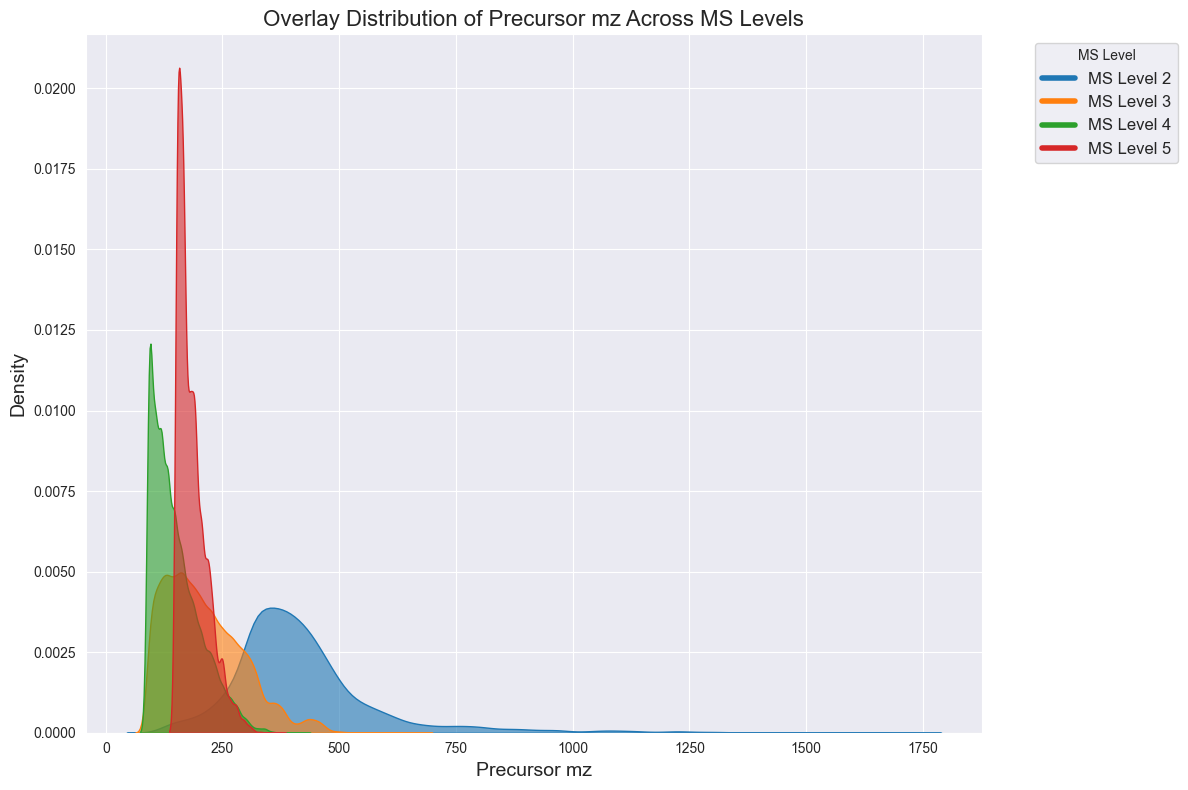

In [63]:
plot_attribute_overlay(data, attribute='precursor_mz', output_svg=False)

### Num of peaks

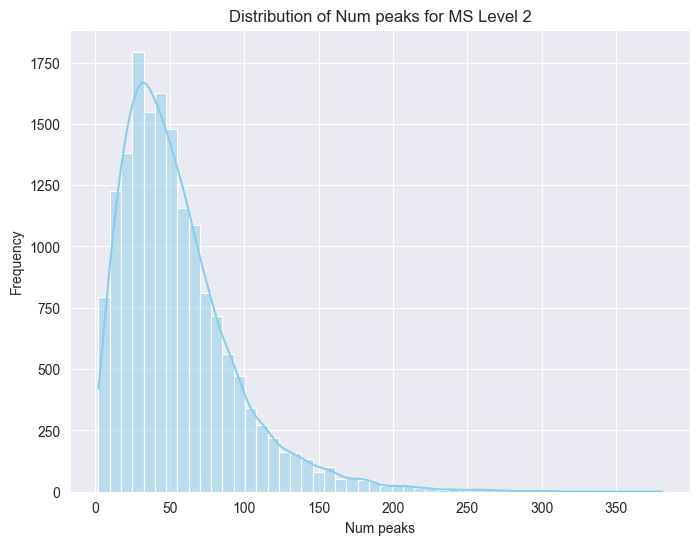

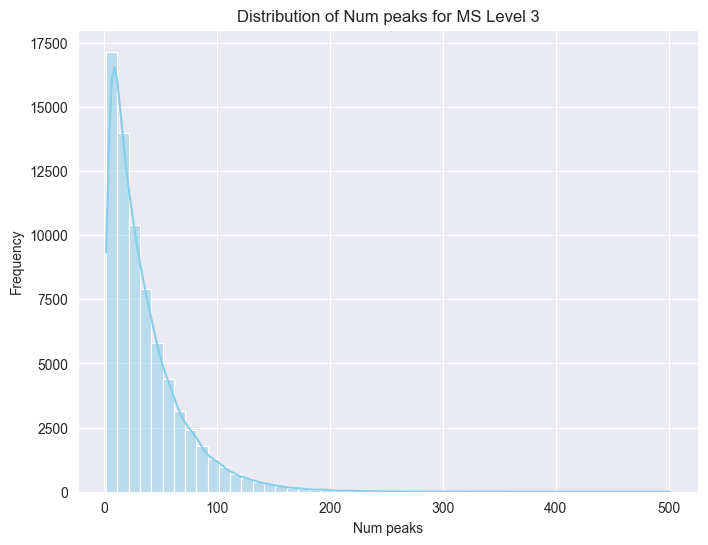

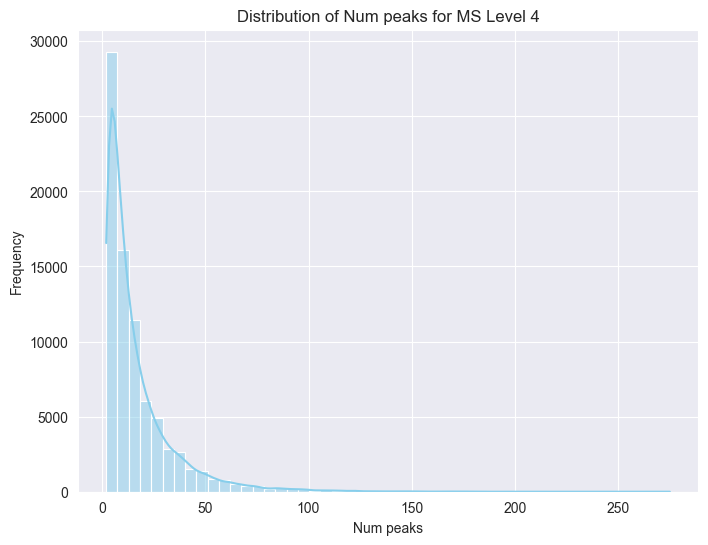

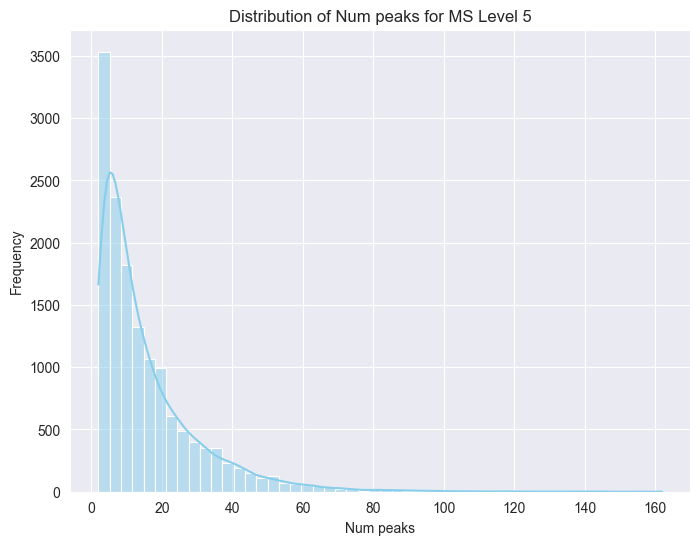

In [71]:
for level_i in data['ms_level'].unique():
    plot_attribute_distribution(data, ms_level=level_i, attribute='num_peaks', output_svg=False)

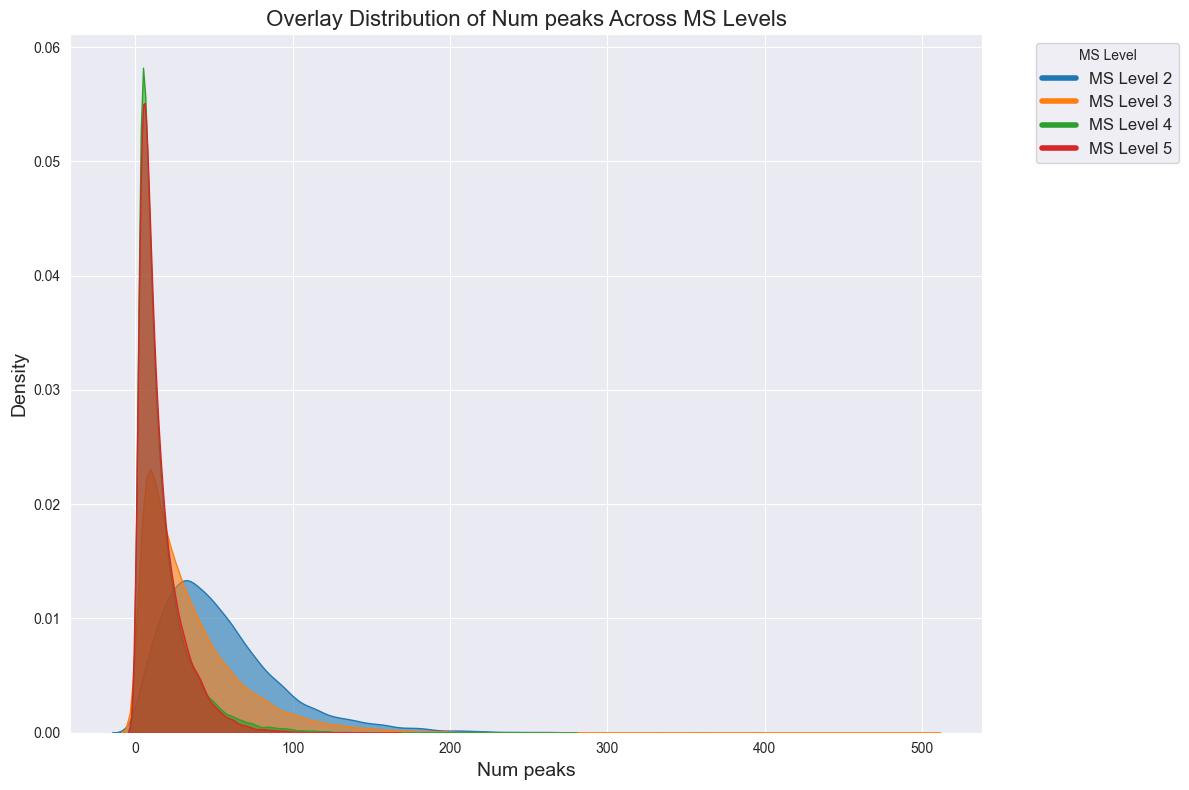

In [72]:
plot_attribute_overlay(data, attribute='num_peaks', output_svg=False)

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_18732/521005037.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


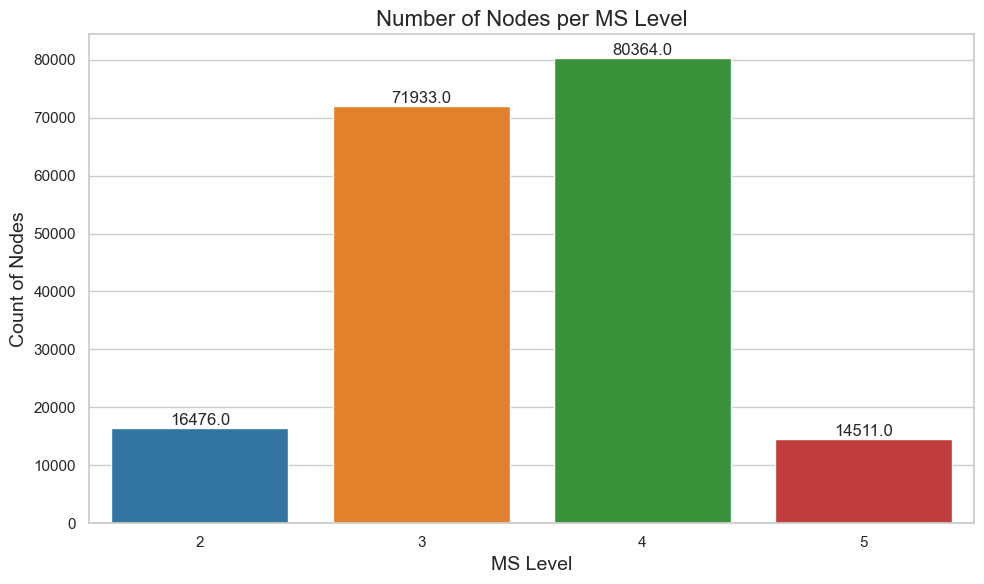

In [73]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(
    x='ms_level',
    data=data,
    palette='tab10',  
    order=sorted(data['ms_level'].unique()) 
)

plt.title('Number of Nodes per MS Level', fontsize=16)
plt.xlabel('MS Level', fontsize=14)
plt.ylabel('Count of Nodes', fontsize=14)

# Add count labels on top of each bar
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height}',
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=12)


plt.tight_layout()
plt.show()

# Dimensionality Reductions

In [76]:
# Extract embeddings as a 2D NumPy array
X = np.vstack(data['embedding'].values)

# Extract MS level labels
y = data['ms_level'].values

In [77]:
# Initialize UMAP with desired parameters
# You can adjust n_neighbors and min_dist based on your dataset
umap_reducer = umap.UMAP(n_neighbors=20, min_dist=0.2, metric='cosine', random_state=42)

# Fit and transform the data
X_umap = umap_reducer.fit_transform(X)

# Add UMAP results to the DataFrame
data['UMAP_1'] = X_umap[:, 0]
data['UMAP_2'] = X_umap[:, 1]

print("UMAP dimensionality reduction completed.")

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP dimensionality reduction completed.


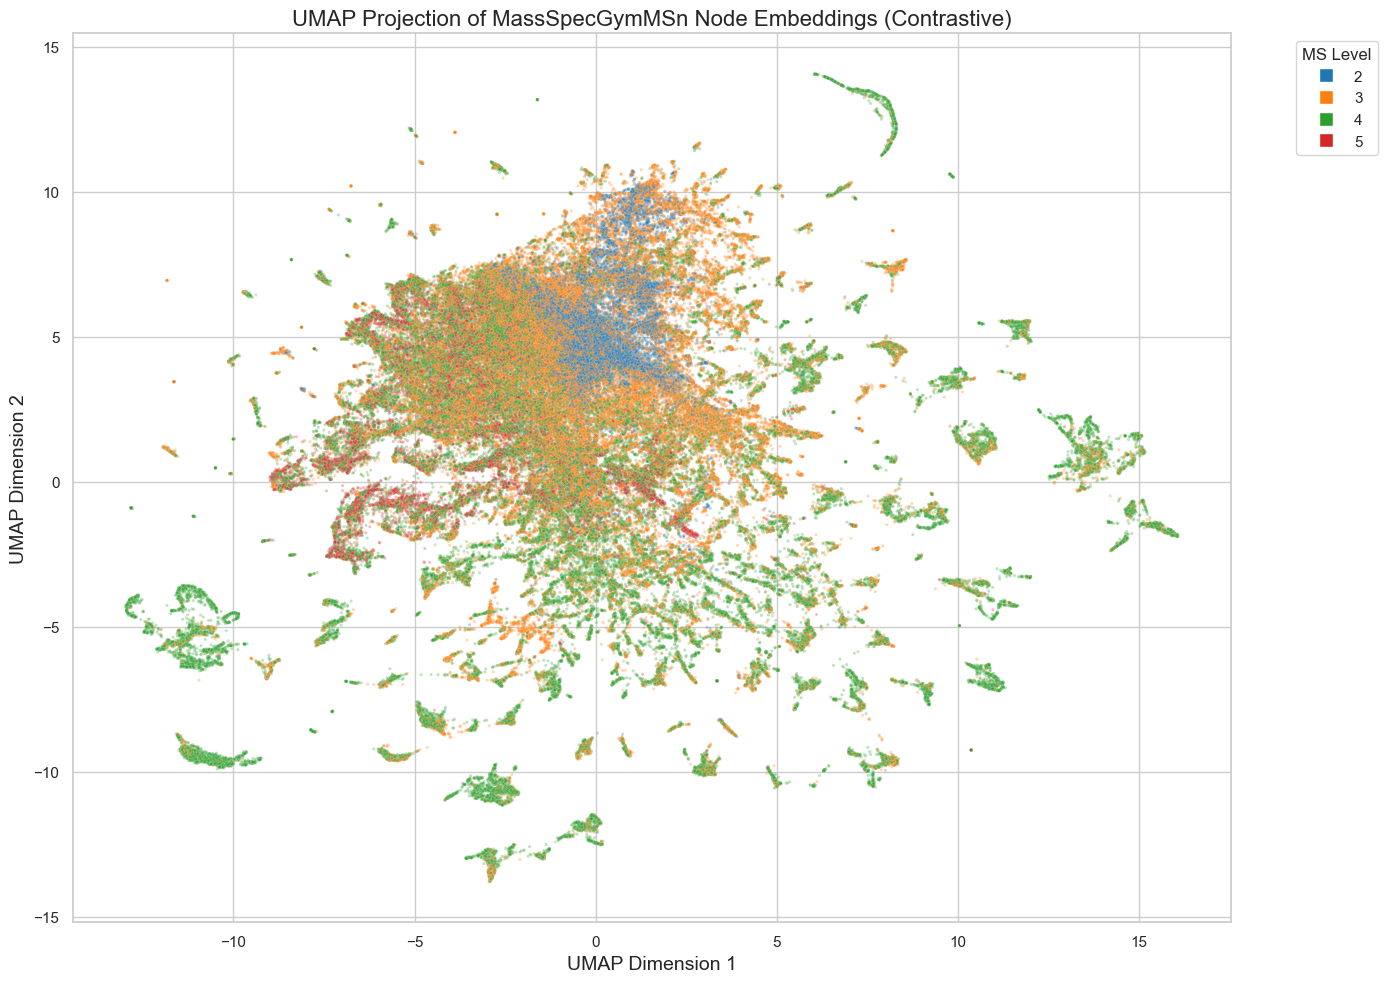

In [78]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Scatter plot with contrastive color palette and adjusted transparency
scatter = sns.scatterplot(
    x='UMAP_1',
    y='UMAP_2',
    hue='ms_level',
    palette='tab10',  # Contrastive palette for better color differentiation
    data=data,
    legend='full',
    alpha=0.3,  # High transparency to reduce overlap effects
    s=5  # Smaller points to reduce clutter
)


# Enhance the plot with titles and labels
plt.title('UMAP Projection of MassSpecGymMSn Node Embeddings (Contrastive)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)


# Custom legend with larger square markers
legend = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markersize=10, label=lbl)
                 for lbl, col in zip(data['ms_level'].unique(), sns.color_palette('tab10', len(data['ms_level'].unique())))]

# Add the custom legend
plt.legend(handles=legend, title='MS Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()

In [111]:
def plot_umap_precursor_mz(data, output_svg=False):
    """
    Plot UMAP projection colored by precursor_mz.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing 'UMAP_1', 'UMAP_2', and 'precursor_mz'.
        output_svg (bool): Whether to save the plot as an SVG file.
    
    Returns:
        None
    """
    # Ensure necessary columns exist
    required_cols = ['UMAP_1', 'UMAP_2', 'precursor_mz']
    if not all(col in data.columns for col in required_cols):
        print(f"DataFrame must contain columns: {required_cols}")
        return
    
    # Remove rows with NaN precursor_mz
    data_clean = data.dropna(subset=['precursor_mz'])
    
    # Check if there are data points after cleaning
    if data_clean.empty:
        print("No data available for plotting precursor_mz distributions.")
        return
    
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 10))
    
    # Create scatter plot with improved transparency and smaller points
    scatter = plt.scatter(
        x=data_clean['UMAP_1'],
        y=data_clean['UMAP_2'],
        c=data_clean['precursor_mz'],
        cmap='viridis',  # Continuous color palette
        alpha=0.5,  # Adjust transparency to reduce overlap
        s=0.4  # Smaller points for better clarity
    )
    
    # Add a colorbar with custom label
    cbar = plt.colorbar(scatter)
    cbar.set_label('Precursor m/z', fontsize=14)
    
    # Enhance the plot with titles and labels
    plt.title('UMAP Projection of MassSpecGymMSn Node Embeddings Colored by Precursor m/z', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)
    
    # Improve layout
    plt.tight_layout()
    
    # Save the plot if needed
    if output_svg:
        plt.savefig('UMAP_Precursor_mz_Overlay.svg', format='svg')
    
    # Show the plot
    plt.show()


def plot_umap_num_peaks(data, bins=10, sample_by_bins=False, output_svg=False):
    """
    Plot UMAP projection colored by num_peaks, with optional bin sampling.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing 'UMAP_1', 'UMAP_2', and 'num_peaks'.
        bins (int): Number of bins to group num_peaks into.
        sample_by_bins (bool): Whether to sample data to balance bins.
        output_svg (bool): Whether to save the plot as an SVG file.
    
    Returns:
        None
    """
    # Ensure necessary columns exist
    required_cols = ['UMAP_1', 'UMAP_2', 'num_peaks']
    if not all(col in data.columns for col in required_cols):
        print(f"DataFrame must contain columns: {required_cols}")
        return
    
    # Make a copy of the DataFrame to avoid modifying the original data
    data_clean = data.copy()
    
    # Remove rows with NaN num_peaks
    data_clean = data_clean.dropna(subset=['num_peaks'])
    
    # Check if there are data points after cleaning
    if data_clean.empty:
        print("No data available for plotting num_peaks distributions.")
        return
    
    # Ensure num_peaks is integer (since it's a count)
    data_clean['num_peaks'] = data_clean['num_peaks'].astype(int)
    
    # Bin the num_peaks values
    min_peaks = data_clean['num_peaks'].min()
    max_peaks = data_clean['num_peaks'].max()
    
    # Define bin edges ensuring all integer values are covered
    bin_edges = np.linspace(min_peaks, max_peaks, bins + 1)
    bin_edges = np.floor(bin_edges).astype(int)
    bin_edges[-1] = max_peaks + 1  # Ensure the max_peaks is included
    
    # Define bin labels as string ranges
    bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
    
    # Assign bins to num_peaks
    data_clean['num_peaks_binned'] = pd.cut(
        data_clean['num_peaks'],
        bins=bin_edges,
        labels=bin_labels,
        include_lowest=True,
        right=False  # Left-inclusive, right-exclusive
    )
    
    # Convert categorical labels to strings for mapping
    data_clean['num_peaks_binned'] = data_clean['num_peaks_binned'].astype(str)
    
    # Sample data by bins if requested
    if sample_by_bins:
        # Find the least populated bin
        bin_counts = data_clean['num_peaks_binned'].value_counts()
        min_bin_size = bin_counts.min()
        
        # Sample an equal number of cases from each bin
        try:
            data_clean = data_clean.groupby('num_peaks_binned').sample(
                n=min_bin_size, random_state=42
            ).reset_index(drop=True)
        except Exception as e:
            print(f"Error during sampling: {e}")
            return
    
    # Assign colors to bins
    if bins <= 10:
        cmap = sns.color_palette("tab10", bins)
    elif bins <= 20:
        cmap = sns.color_palette("tab20", bins)
    else:
        cmap = sns.color_palette("viridis", bins)
    
    bin_colors = dict(zip(bin_labels, cmap))
    
    # Map colors to binned data
    data_clean['bin_color'] = data_clean['num_peaks_binned'].map(bin_colors)
    
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 10))
    
    # Create scatter plot
    plt.scatter(
        x=data_clean['UMAP_1'],
        y=data_clean['UMAP_2'],
        c=data_clean['bin_color'],
        alpha=0.6,
        s=10
    )
    
    # Create a custom legend
    present_bins = data_clean['num_peaks_binned'].unique()
    custom_legend = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=bin_colors[bin_label], markersize=10, label=bin_label)
        for bin_label in present_bins
    ]
    plt.legend(handles=custom_legend, title='Num Peaks Binned', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Enhance the plot with titles and labels
    plt.title('UMAP Projection Colored by Binned Num Peaks', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if needed
    if output_svg:
        plt.savefig('UMAP_Num_Peaks_Overlay.svg', format='svg')
    
    # Show the plot
    plt.show()
    
def plot_umap_num_peaks_proportional(data, bins=10, sample_by_bins=False, max_per_bin=1000, output_svg=False):
    """
    Plot UMAP projection colored by num_peaks, with optional proportional bin sampling.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing 'UMAP_1', 'UMAP_2', and 'num_peaks'.
        bins (int): Number of bins to group num_peaks into.
        sample_by_bins (bool): Whether to sample data to balance bins proportionally.
        max_per_bin (int): Maximum number of samples per bin to prevent overplotting.
        output_svg (bool): Whether to save the plot as an SVG file.
    
    Returns:
        None
    """
    # Ensure necessary columns exist
    required_cols = ['UMAP_1', 'UMAP_2', 'num_peaks']
    if not all(col in data.columns for col in required_cols):
        print(f"DataFrame must contain columns: {required_cols}")
        return
    
    # Make a copy of the DataFrame to avoid modifying the original data
    data_clean = data.copy()
    
    # Remove rows with NaN num_peaks
    data_clean = data_clean.dropna(subset=['num_peaks'])
    
    # Check if there are data points after cleaning
    if data_clean.empty:
        print("No data available for plotting num_peaks distributions.")
        return
    
    # Ensure num_peaks is integer (since it's a count)
    data_clean['num_peaks'] = data_clean['num_peaks'].astype(int)
    
    # Bin the num_peaks values
    min_peaks = data_clean['num_peaks'].min()
    max_peaks = data_clean['num_peaks'].max()
    
    # Define bin edges ensuring all integer values are covered
    bin_edges = np.linspace(min_peaks, max_peaks, bins + 1)
    bin_edges = np.floor(bin_edges).astype(int)
    bin_edges[-1] = max_peaks + 1  # Ensure the max_peaks is included
    
    # Define bin labels as string ranges
    bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
    
    # Assign bins to num_peaks
    data_clean['num_peaks_binned'] = pd.cut(
        data_clean['num_peaks'],
        bins=bin_edges,
        labels=bin_labels,
        include_lowest=True,
        right=False  # Left-inclusive, right-exclusive
    )
    
    # Convert categorical labels to strings for mapping
    data_clean['num_peaks_binned'] = data_clean['num_peaks_binned'].astype(str)
    
    # Sample data by bins proportionally if requested
    if sample_by_bins:
        # Calculate bin counts
        bin_counts = data_clean['num_peaks_binned'].value_counts()
        
        # Define sampling rate inversely proportional to bin frequency
        sampling_rates = (1 / bin_counts).sort_index()
        # Normalize sampling rates
        sampling_rates = sampling_rates / sampling_rates.max()
        
        # Apply sampling rate with a cap
        sampled_dfs = []
        for bin_label, rate in sampling_rates.items():
            bin_df = data_clean[data_clean['num_peaks_binned'] == bin_label]
            n_samples = min(int(len(bin_df) * rate), max_per_bin)
            if n_samples > 0:
                sampled_bin_df = bin_df.sample(n=n_samples, random_state=42)
                sampled_dfs.append(sampled_bin_df)
        
        # Concatenate sampled data
        data_clean = pd.concat(sampled_dfs).reset_index(drop=True)
    
    # Assign colors to bins
    if bins <= 10:
        cmap = sns.color_palette("tab10", bins)
    elif bins <= 20:
        cmap = sns.color_palette("tab20", bins)
    else:
        cmap = sns.color_palette("viridis", bins)
    
    bin_colors = dict(zip(bin_labels, cmap))
    
    # Map colors to binned data
    data_clean['bin_color'] = data_clean['num_peaks_binned'].map(bin_colors)
    
    # Handle unmapped bins
    unmapped_bins = data_clean['num_peaks_binned'].isna().sum()
    if unmapped_bins > 0:
        print(f"Warning: {unmapped_bins} data points have bins that were not mapped to colors.")
    
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 10))
    
    # Create scatter plot
    plt.scatter(
        x=data_clean['UMAP_1'],
        y=data_clean['UMAP_2'],
        c=data_clean['bin_color'],
        alpha=0.6,
        s=0.5
    )
    
    # Create a custom legend
    present_bins = data_clean['num_peaks_binned'].unique()
    custom_legend = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=bin_colors[bin_label], markersize=10, label=bin_label)
        for bin_label in present_bins
    ]
    plt.legend(handles=custom_legend, title='Num Peaks Binned', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Enhance the plot with titles and labels
    plt.title('UMAP Projection Colored by Binned Num Peaks (Proportional Sampling)', fontsize=16)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot if needed
    if output_svg:
        plt.savefig('UMAP_Num_Peaks_Overlay_Proportional.svg', format='svg')
    
    # Show the plot
    plt.show()

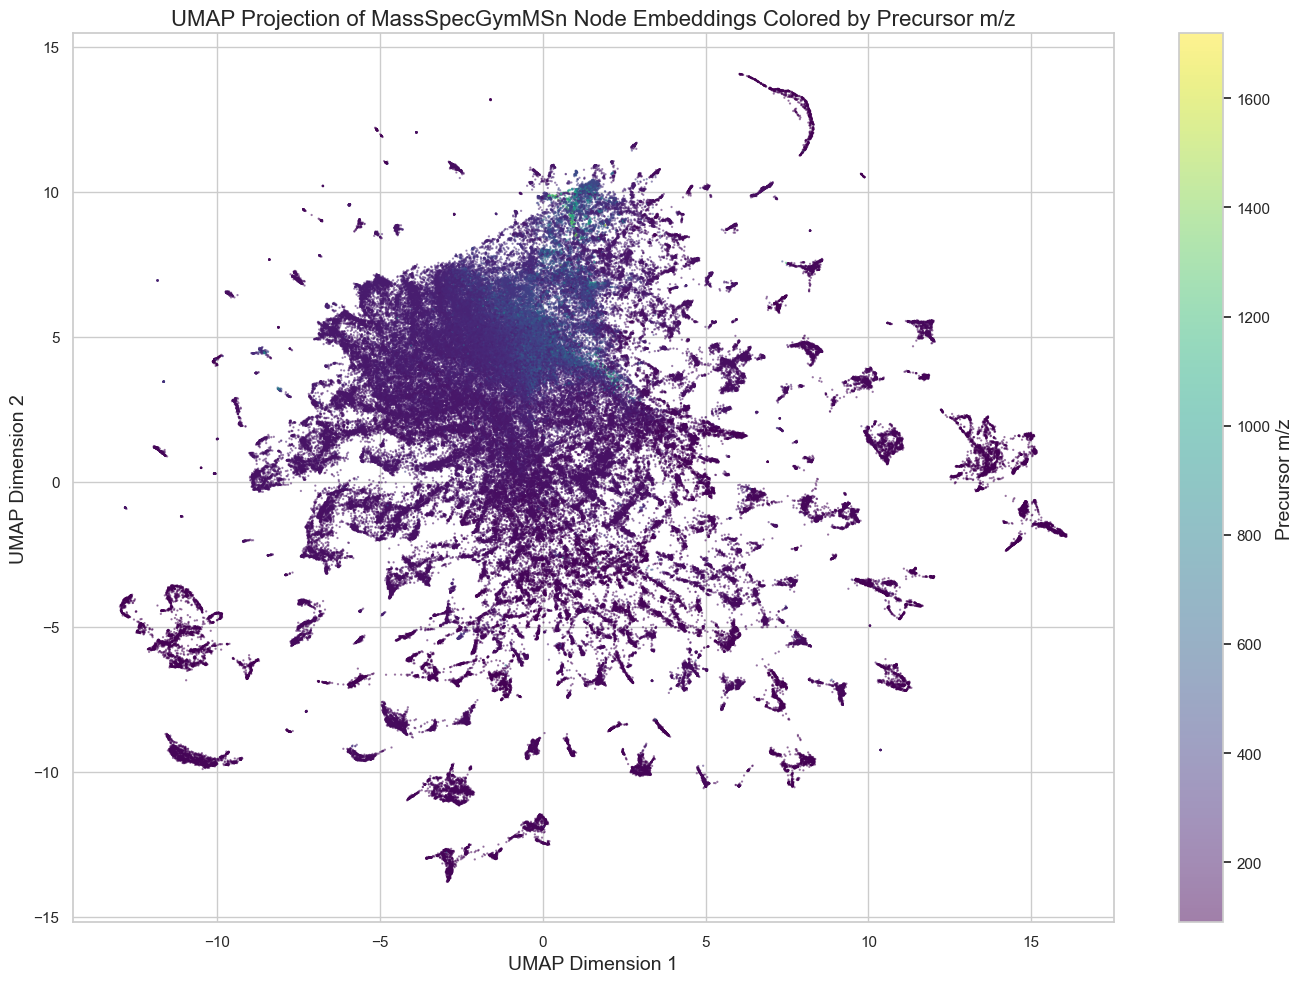

In [84]:
plot_umap_precursor_mz(data, output_svg=False)

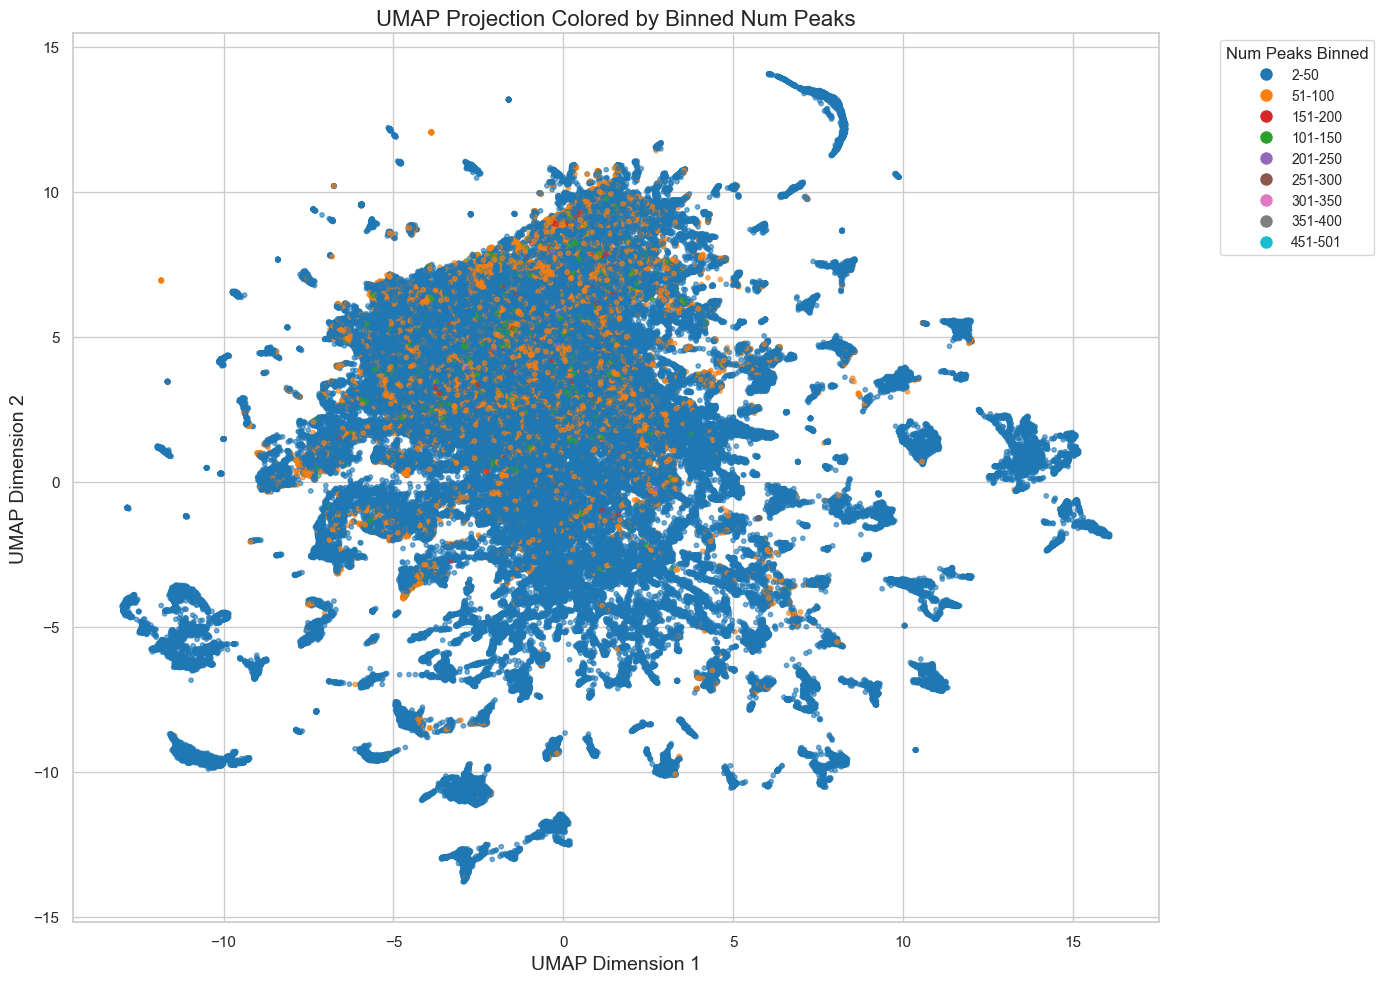

In [104]:
plot_umap_num_peaks(data, bins=10, output_svg=False)

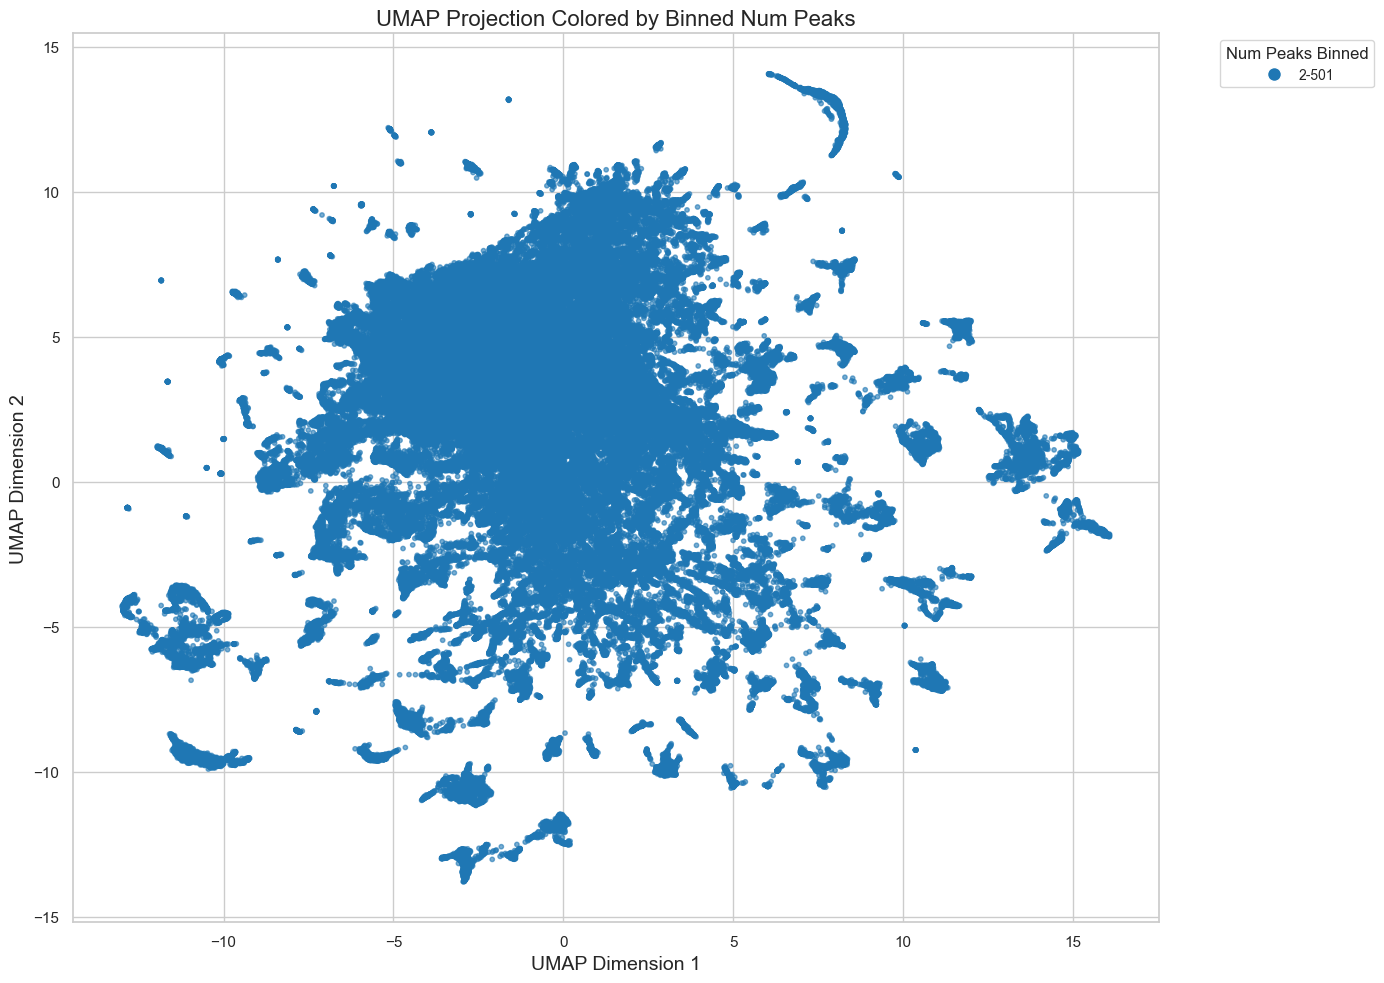

In [108]:
plot_umap_num_peaks(data, bins=1, sample_by_bins=True, output_svg=False)

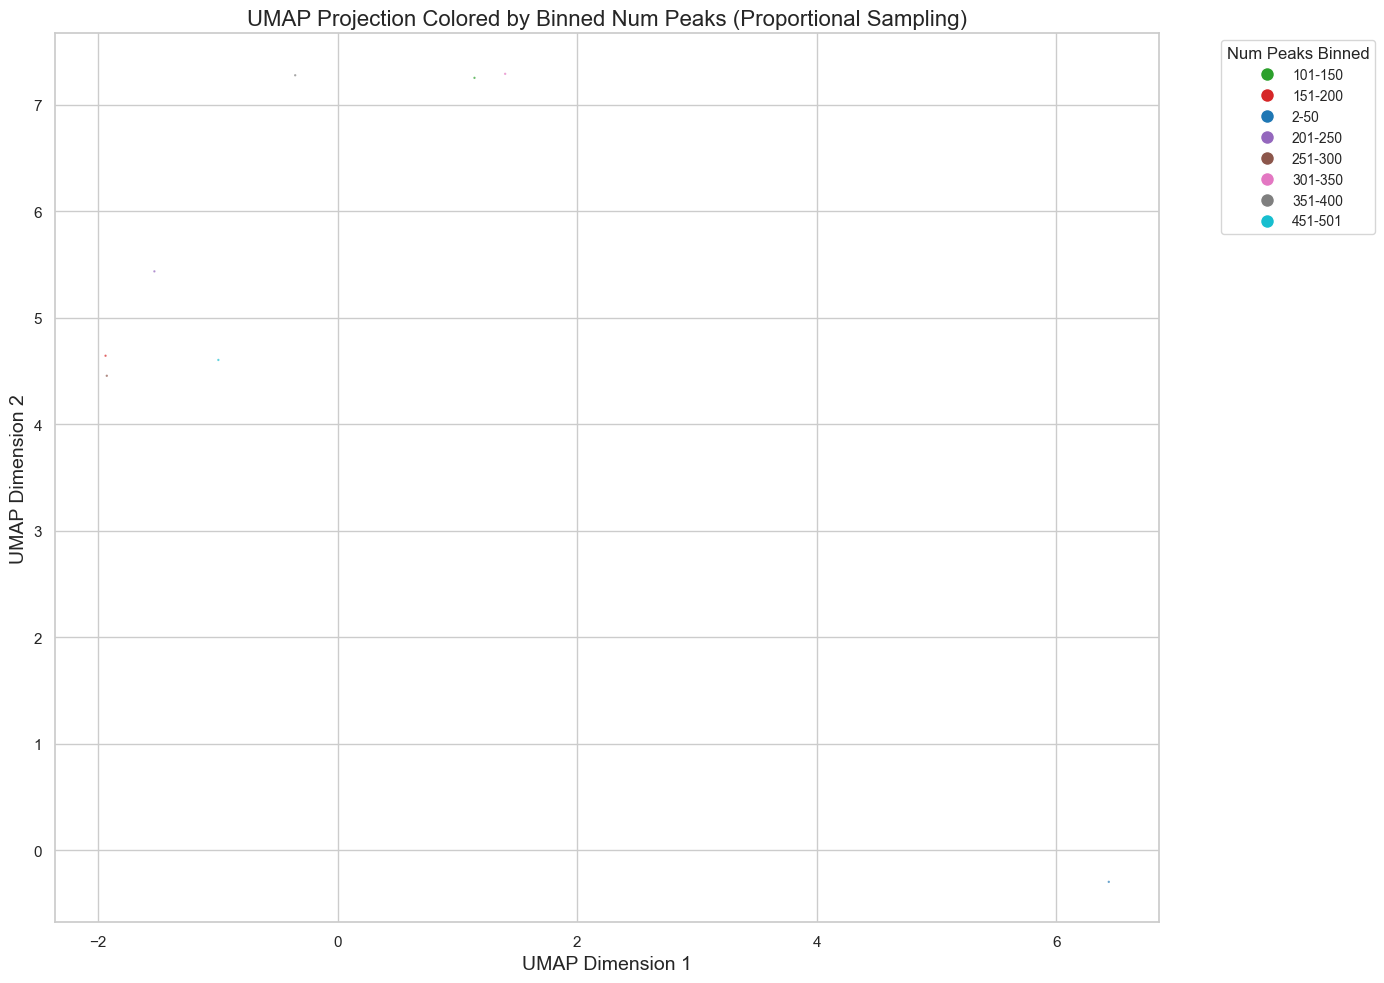

In [118]:
plot_umap_num_peaks_proportional(data, bins=10, sample_by_bins=True, max_per_bin=13, output_svg=False)

In [119]:
def investigate_num_peaks_bins(data, bins=10):
    """
    Divide the 'num_peaks' column into specified number of bins and print the number of samples in each bin.

    Parameters:
        data (pd.DataFrame): DataFrame containing 'num_peaks'.
        bins (int): Number of bins to divide 'num_peaks' into.

    Returns:
        None
    """
    # 1. Validate the presence of required columns
    required_cols = ['num_peaks']
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        print(f"Error: DataFrame is missing the following required column(s): {missing_cols}")
        return
    
    # 2. Remove rows with missing 'num_peaks'
    data_clean = data.dropna(subset=['num_peaks']).copy()
    
    if data_clean.empty:
        print("The DataFrame has no rows with valid 'num_peaks' data.")
        return
    
    # 3. Convert 'num_peaks' to integer type
    try:
        data_clean['num_peaks'] = data_clean['num_peaks'].astype(int)
    except ValueError:
        print("Error: 'num_peaks' column contains non-integer values that cannot be converted.")
        return
    
    # 4. Determine the range of 'num_peaks'
    min_peaks = data_clean['num_peaks'].min()
    max_peaks = data_clean['num_peaks'].max()
    
    print(f"num_peaks Range: {min_peaks} to {max_peaks}")
    
    # 5. Define bin edges using linspace for equal-width bins
    bin_edges = np.linspace(min_peaks, max_peaks, bins + 1)
    bin_edges = np.floor(bin_edges).astype(int)  # Ensure integer bin edges
    bin_edges[-1] = max_peaks + 1  # Include the maximum value in the last bin
    
    # 6. Create bin labels
    bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
    
    # 7. Assign bins to 'num_peaks'
    data_clean['num_peaks_binned'] = pd.cut(
        data_clean['num_peaks'],
        bins=bin_edges,
        labels=bin_labels,
        include_lowest=True,
        right=False  # Left-inclusive, right-exclusive
    )
    
    # 8. Count the number of samples in each bin
    bin_counts = data_clean['num_peaks_binned'].value_counts().sort_index()
    
    # 9. Create a summary DataFrame for better readability
    bin_summary = pd.DataFrame({
        'Bin Range': bin_labels,
        'Sample Count': bin_counts.values
    })
    
    # 10. Display the bin summary
    print("\nNumber of samples in each bin:")
    print(bin_summary.to_string(index=False))
    
    # 11. Optionally, return the summary for further use
    return bin_summary

In [120]:
bin_summary = investigate_num_peaks_bins(data, bins=10)

num_peaks Range: 2 to 501

Number of samples in each bin:
Bin Range  Sample Count
     2-50        153770
   51-100         23314
  101-150          4741
  151-200          1095
  201-250           254
  251-300            79
  301-350            21
  351-400             9
  401-450             0
  451-501             1


Bin Range  Sample Count
0      2-50        153770
1    51-100         23314
2   101-150          4741
3   151-200          1095
4   201-250           254
5   251-300            79
6   301-350            21
7   351-400             9
8   401-450             0
9   451-501             1

In [ ]:
# Calculate total samples
total_samples = bin_summary['Sample Count'].sum()

# Add percentage column
bin_summary['Percentage (%)'] = (bin_summary['Sample Count'] / total_samples * 100).round(2)

print("\nNumber of samples and percentage in each bin:")
print(bin_summary.to_string(index=False))

### Balance Nodes By Level

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_18732/1027857376.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('ms_level').apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)


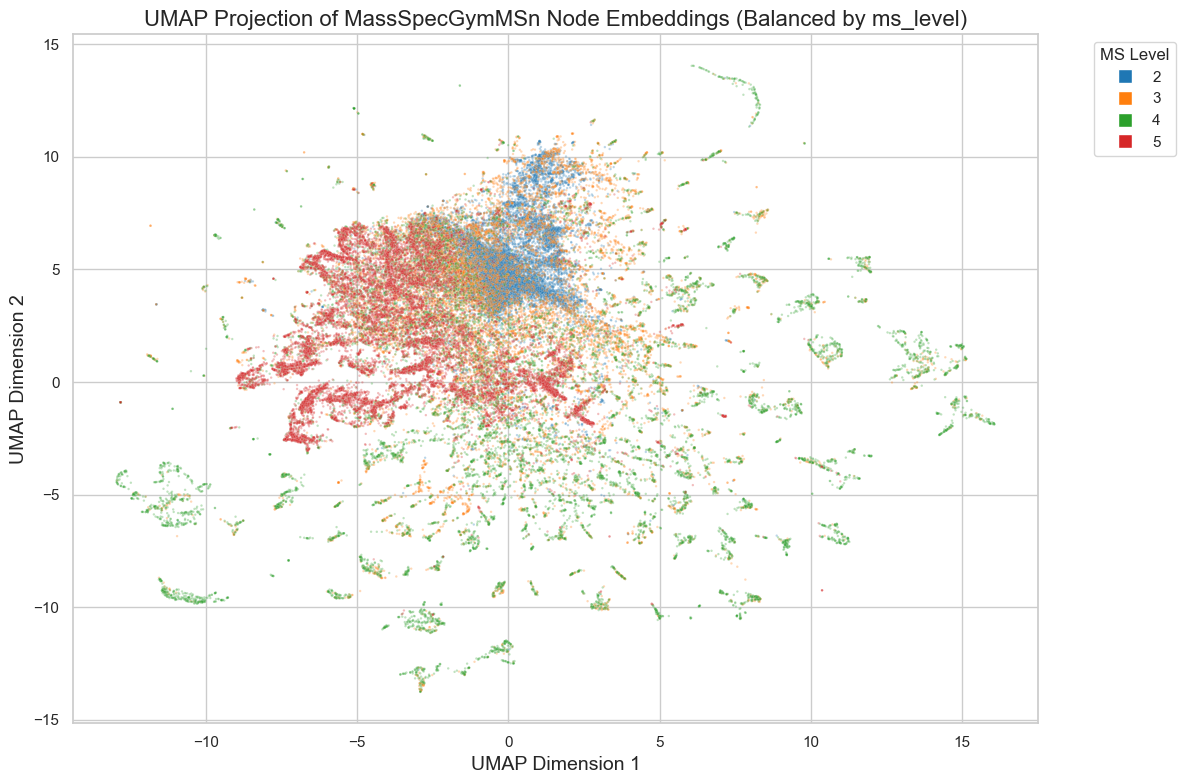

In [121]:
# Determine the minimum number of samples across all ms_levels
min_samples = data['ms_level'].value_counts().min()

# Balance the dataset by sampling min_samples from each ms_level
balanced_data = data.groupby('ms_level').apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)

# Plot the balanced data
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x='UMAP_1',
    y='UMAP_2',
    hue='ms_level',
    palette='tab10',  
    data=balanced_data,
    legend='full',
    alpha=0.3,  # Adjust transparency to reduce overlap
    s=3  # Adjust point size
)

plt.title('UMAP Projection of MassSpecGymMSn Node Embeddings (Balanced by ms_level)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)

# Custom legend with larger square markers
legend = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markersize=10, label=lbl)
                 for lbl, col in zip(data['ms_level'].unique(), sns.color_palette('tab10', len(data['ms_level'].unique())))]

# Add the custom legend
plt.legend(handles=legend, title='MS Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()

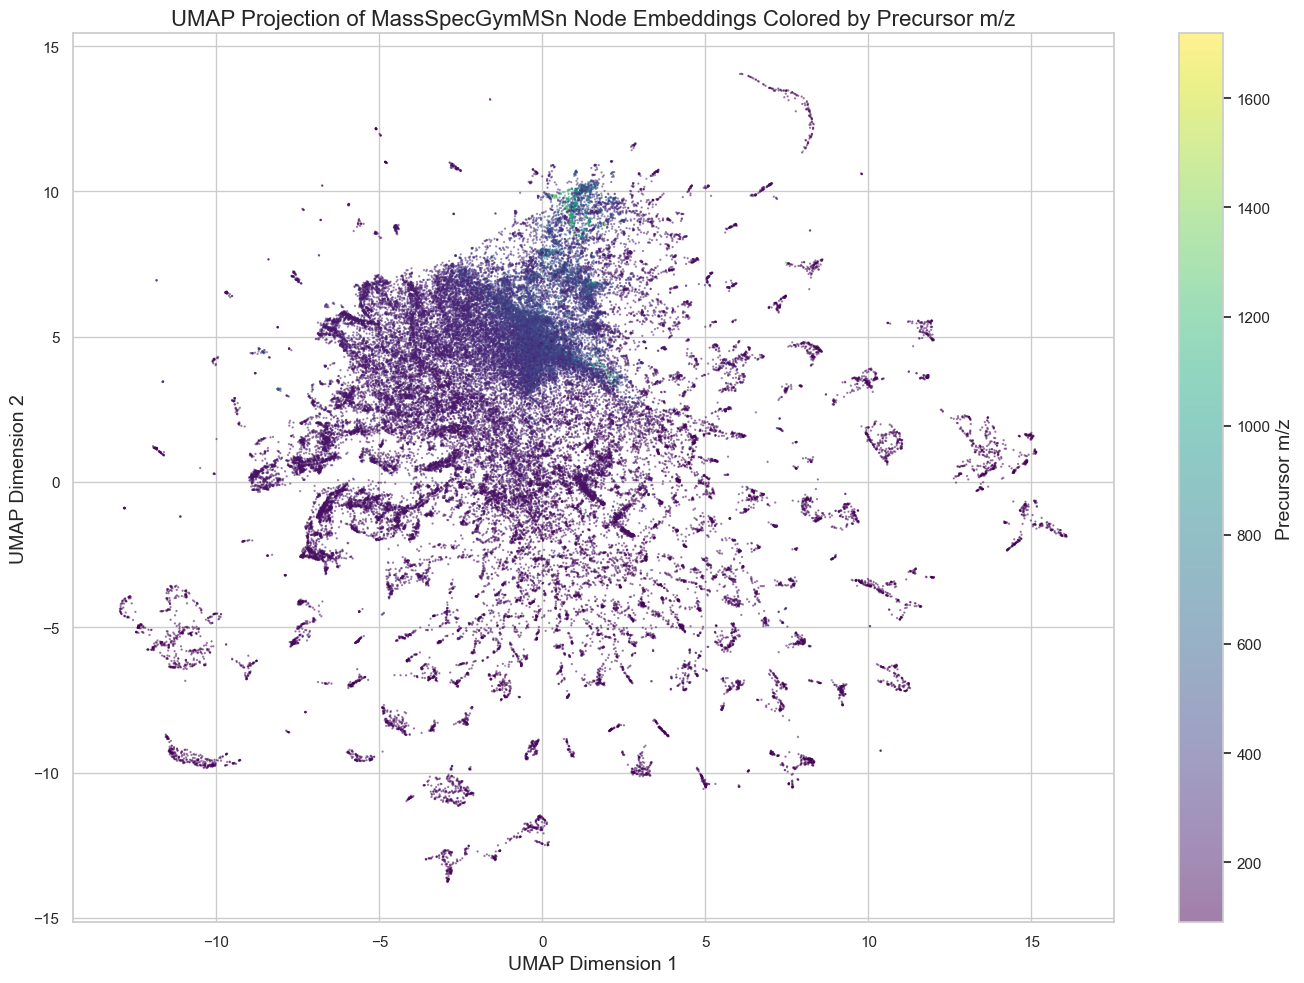

In [122]:
plot_umap_precursor_mz(balanced_data, output_svg=False)

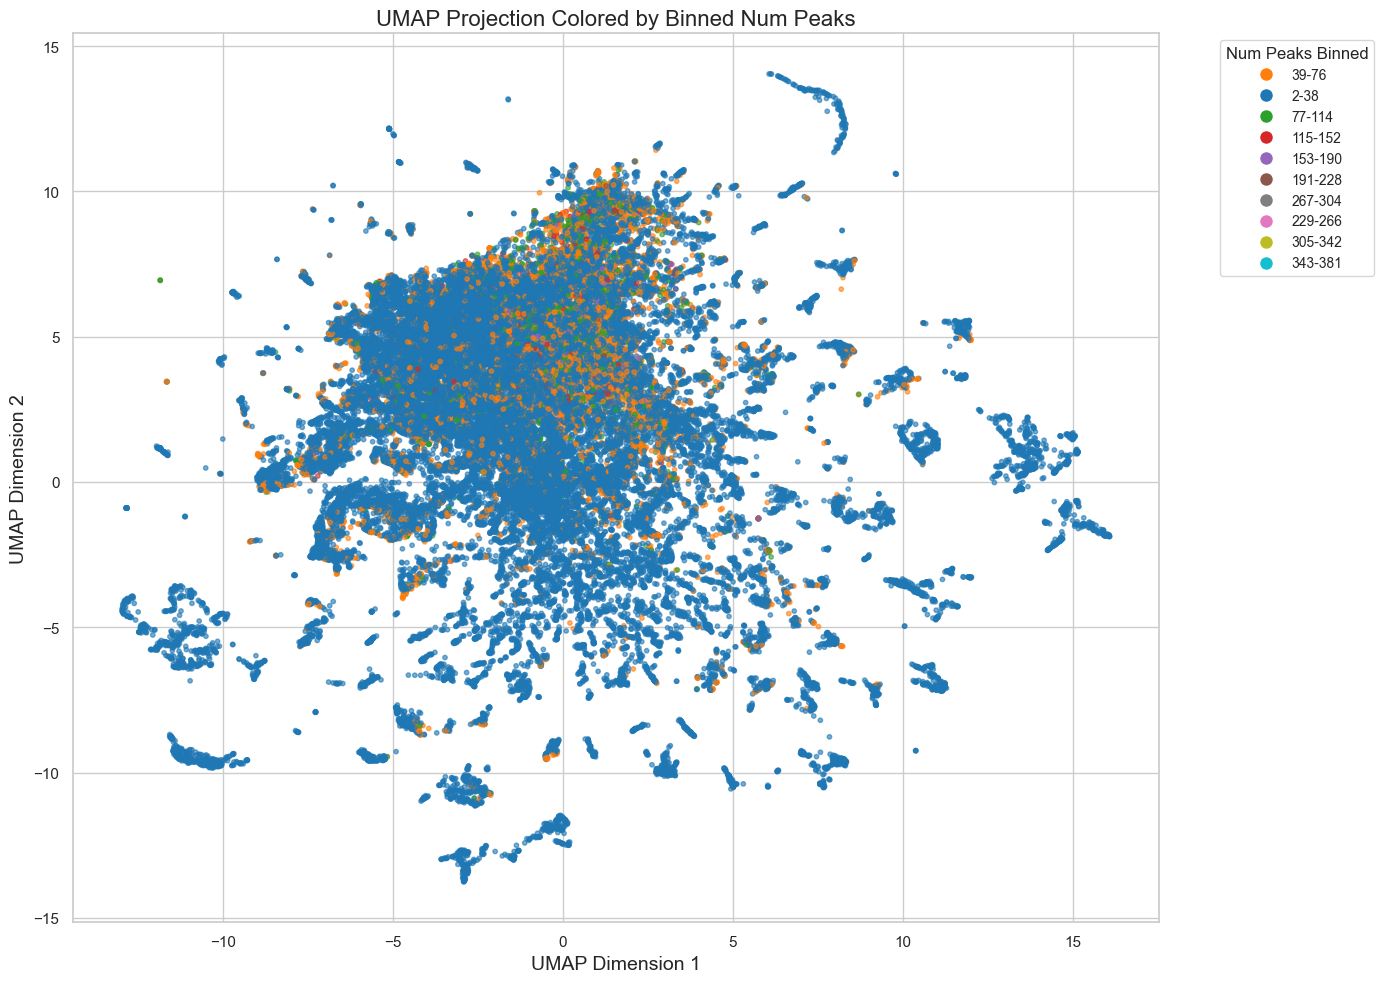

In [123]:
plot_umap_num_peaks(balanced_data, bins=10, output_svg=False)

### TSNE

In [124]:
# Define the maximum number of samples per MS level
max_samples_per_level = 10000

# Perform sampling
sampled_data = sample_per_level(data, max_samples_per_level)

print(f"Sampled data contains {len(sampled_data)} nodes across {sampled_data['ms_level'].nunique()} MS levels.")

Sampled data contains 40000 nodes across 4 MS levels.


/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_18732/197504315.py:146: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = grouped.apply(lambda x: x.sample(n=min(len(x), max_samples), random_state=42))


In [125]:
# Extract embeddings as a 2D NumPy array
X_sampled = np.vstack(sampled_data['embedding'].values)

# Extract MS level labels
y_sampled = sampled_data['ms_level'].values

In [126]:
# Initialize t-SNE with optimized parameters for speed
tsne = TSNE(
    n_components=2,
    perplexity=30,          # You can adjust based on dataset size and structure
    learning_rate=200,      # Common default
    n_iter=1000,            # Number of iterations
    random_state=42,
    metric='cosine',
    verbose=1               # To monitor progress
)

X_tsne_sampled = tsne.fit_transform(X_sampled)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.008s...


/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 40000 samples in 23.815s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for sample 13000 / 40000
[t-SNE] Computed conditional probabilities for sample 14000 / 4000

In [127]:
# Add t-SNE results to the sampled DataFrame
sampled_data['tSNE_1'] = X_tsne_sampled[:, 0]
sampled_data['tSNE_2'] = X_tsne_sampled[:, 1]

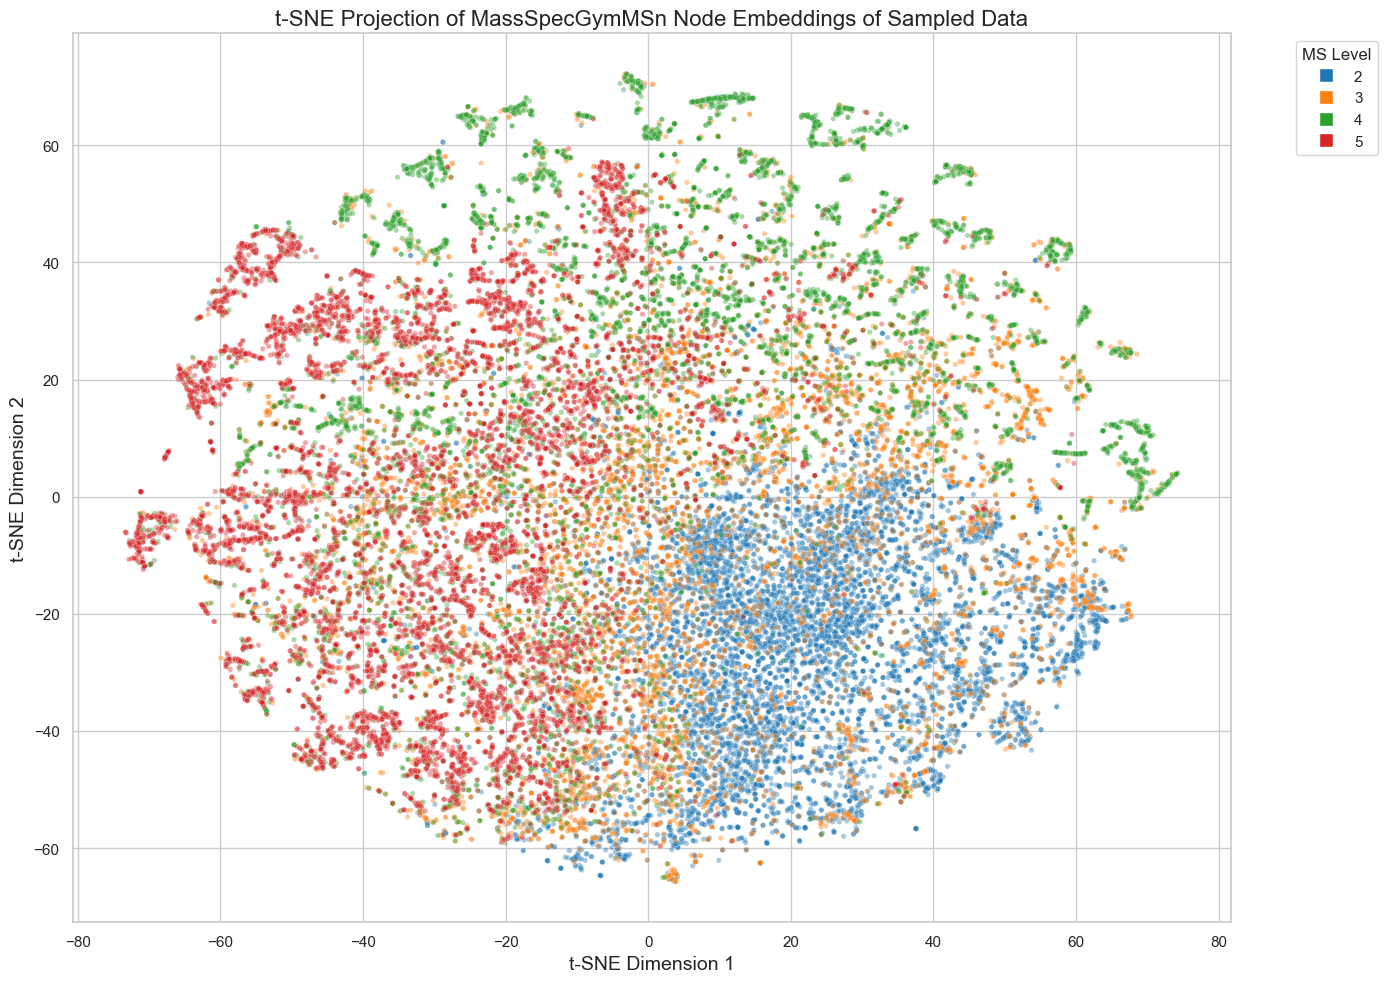

In [128]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Scatter plot with contrastive color palette and adjusted transparency
sns.scatterplot(
    x='tSNE_1',
    y='tSNE_2',
    hue='ms_level',
    palette='tab10',  # Contrastive palette for better color differentiation
    data=sampled_data,
    legend='full',
    alpha=0.4,  # High transparency to reduce overlap effects
    s=15  # Smaller points to reduce clutter
)


# Enhance the plot with titles and labels
plt.title('t-SNE Projection of MassSpecGymMSn Node Embeddings of Sampled Data', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)

# Custom legend with larger square markers
legend = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markersize=10, label=lbl)
                 for lbl, col in zip(data['ms_level'].unique(), sns.color_palette('tab10', len(data['ms_level'].unique())))]

# Add the custom legend
plt.legend(handles=legend, title='MS Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Show the plot
plt.show()

In [129]:
# Initialize t-SNE with desired parameters
# You can adjust perplexity and learning_rate based on your dataset
# tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42, metric='euclidean')
# 
# # Fit and transform the data
# X_tsne = tsne.fit_transform(X)
# 
# # Add t-SNE results to the DataFrame
# data['tSNE_1'] = X_tsne[:, 0]
# data['tSNE_2'] = X_tsne[:, 1]
# 
# print("t-SNE dimensionality reduction completed.")

# TMAP

In [130]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.cluster import DBSCAN
# from tmap.tda import mapper, Filter
# from tmap.tda.cover import Cover
# from tmap.tda.plot import Color
# import networkx as nx
# from typing import Dict, Optional
# 
# # Optional: Suppress warnings for cleaner output
# import warnings
# warnings.filterwarnings('ignore')

In [131]:
# # Standardize the embeddings
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_sampled)

In [132]:
# # Initialize Mapper
# tm = mapper.Mapper(verbose=1)
# 
# # Define the filter using MDS (Multidimensional Scaling)
# lens = [Filter.MDS(components=[0, 1], random_state=100)]
# 
# # Project the data using the defined filter
# projected_X = tm.filter(X_scaled, lens=lens)
# 
# # Initialize the clustering algorithm
# clusterer = DBSCAN(eps=0.75, min_samples=1)
# 
# # Define the cover parameters
# cover = Cover(
#     projected_data=MinMaxScaler().fit_transform(projected_X),
#     resolution=20,    # Determines the granularity; adjust as needed
#     overlap=0.75      # Overlap between cover sets; adjust as needed
# )

In [133]:
# # Perform Mapper to create the TDA graph
# print("Creating TDA graph with TMAP...")
# graph = tm.map(
#     data=X_scaled,
#     cover=cover,
#     clusterer=clusterer
# )
# print(f"TDA graph created with {len(graph.nodes)} nodes and {len(graph.edges)} edges.")

In [134]:
# # Initialize a dictionary to store MS levels per TMAP node
# tmap_node_levels = {}
# 
# # Iterate over each node in the graph
# for node_idx, node_data in graph.nodes(data=True):
#     # node_data['data'] contains the indices of data points in this TMAP node
#     data_indices = node_data['data']
#     if len(data_indices) == 0:
#         # Handle empty nodes if any
#         tmap_node_levels[node_idx] = None
#         continue
#     # Extract MS levels of the data points in this node
#     node_ms_levels = sampled_data.iloc[data_indices]['ms_level']
#     # Determine the most common MS level in this node
#     predominant_level = node_ms_levels.mode()[0]
#     tmap_node_levels[node_idx] = predominant_level
# 
# # Add MS level information to the graph nodes
# nx.set_node_attributes(graph, tmap_node_levels, 'ms_level')

## Between tree similarity

In [135]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import time

In [136]:
# Extract tree_ids as a NumPy array for efficient indexing
tree_ids = data['tree_id'].values

# Verify the unique number of trees
num_unique_trees = len(np.unique(tree_ids))
print(f"Number of unique trees: {num_unique_trees}")

Number of unique trees: 16476


In [137]:
# Extract embeddings as a 2D NumPy array
embeddings = np.vstack(data['embedding'].values)

# Normalize embeddings to unit vectors
embeddings_normalized = normalize(embeddings, norm='l2')

print("Embeddings have been normalized.")

Embeddings have been normalized.


In [138]:
# Define the number of neighbors (excluding the node itself)
k = 10

# Initialize NearestNeighbors with cosine metric
# Note: Cosine distance = 1 - cosine similarity
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric='cosine')

nbrs.fit(embeddings_normalized)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)

In [ ]:
distances, indices = nbrs.kneighbors(embeddings_normalized)

# Inspect the shape of the results
print(f"Distances shape: {distances.shape}")
print(f"Indices shape: {indices.shape}")

In [51]:
# Get the tree_id of each node
node_tree_ids = data['tree_id'].values  # Shape: (180000,)

# Get the tree_ids of the neighbors (excluding self)
neighbor_tree_ids = data['tree_id'].values[indices[:, 1:]]  # Shape: (180000, 10)

# Verify shapes
print(f"Node tree_ids shape: {node_tree_ids.shape}")
print(f"Neighbor tree_ids shape: {neighbor_tree_ids.shape}")

Node tree_ids shape: (183284,)
Neighbor tree_ids shape: (183284, 10)


In [52]:
# Compare neighbor tree_ids with node's tree_id
same_tree = (neighbor_tree_ids == node_tree_ids[:, np.newaxis])

# Count the number of same-tree neighbors for each node
same_tree_counts = same_tree.sum(axis=1)  # Shape: (180000,)

# Add the counts to the DataFrame
data['same_tree_knn'] = same_tree_counts

count    183284.000000
mean          0.694501
std           1.122290
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          10.000000
Name: same_tree_knn, dtype: float64


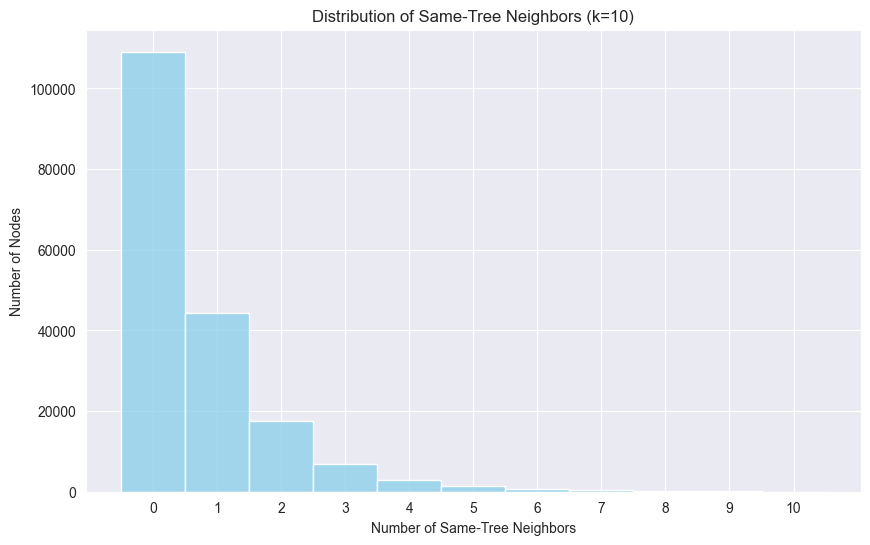

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(data['same_tree_knn'], bins=range(0, k+2), discrete=True, kde=False, color='skyblue')
plt.title(f'Distribution of Same-Tree Neighbors (k={k})')
plt.xlabel('Number of Same-Tree Neighbors')
plt.ylabel('Number of Nodes')
plt.xticks(range(0, k+1))
plt.show()

In [54]:
# Shuffle the tree_ids to simulate random assignments
np.random.seed(42)  # For reproducibility
shuffled_tree_ids = np.random.permutation(node_tree_ids)

# Create a copy of the DataFrame for shuffled analysis
data_shuffled = data.copy()
data_shuffled['shuffled_tree_id'] = shuffled_tree_ids

# Get the shuffled tree_ids of the neighbors
shuffled_neighbor_tree_ids = shuffled_tree_ids[indices[:, 1:]]  # Shape: (180000, 10)

# Compare shuffled neighbor tree_ids with shuffled node's tree_id
shuffled_same_tree = (shuffled_neighbor_tree_ids == shuffled_tree_ids[:, np.newaxis])

# Count the number of same-tree neighbors in shuffled data
shuffled_same_tree_counts = shuffled_same_tree.sum(axis=1)  # Shape: (180000,)

# Add to the shuffled DataFrame
data_shuffled['same_tree_knn_shuffled'] = shuffled_same_tree_counts

# Optional: Display summary statistics
print(data_shuffled['same_tree_knn_shuffled'].describe())

count    183284.000000
mean          0.008975
std           0.094311
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: same_tree_knn_shuffled, dtype: float64


/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_1100/3583342115.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['same_tree_knn'], label='Actual', shade=True, color='blue')
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_1100/3583342115.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_shuffled['same_tree_knn_shuffled'], label='Shuffled', shade=True, color='orange')


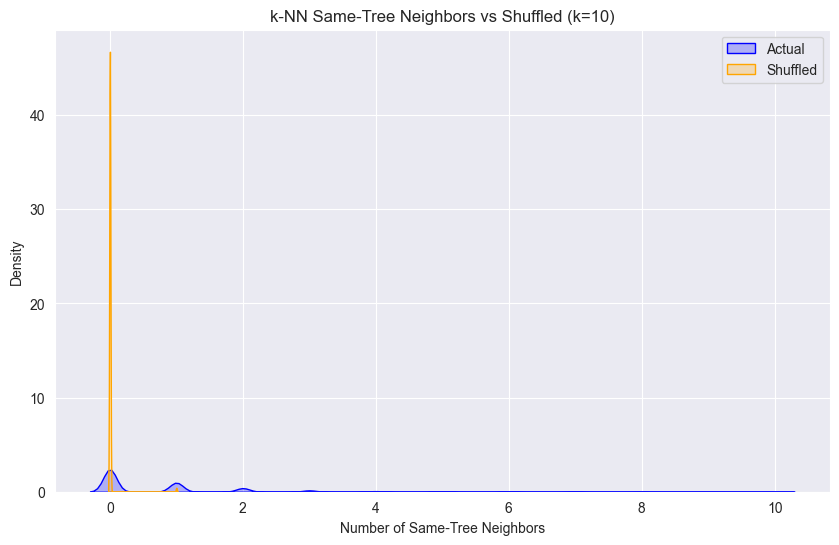

In [55]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data['same_tree_knn'], label='Actual', shade=True, color='blue')
sns.kdeplot(data_shuffled['same_tree_knn_shuffled'], label='Shuffled', shade=True, color='orange')
plt.title(f'k-NN Same-Tree Neighbors vs Shuffled (k={k})')
plt.xlabel('Number of Same-Tree Neighbors')
plt.ylabel('Density')
plt.legend()
plt.show()

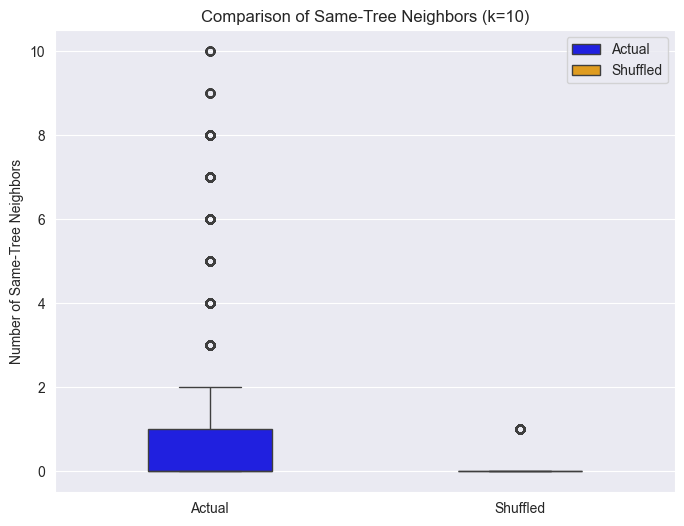

In [56]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data[['same_tree_knn']], color='blue', width=0.4, label='Actual')
sns.boxplot(data=data_shuffled[['same_tree_knn_shuffled']], color='orange', width=0.4, label='Shuffled')
plt.title(f'Comparison of Same-Tree Neighbors (k={k})')
plt.ylabel('Number of Same-Tree Neighbors')
plt.xticks([0, 1], ['Actual', 'Shuffled'])
plt.legend()
plt.show()

In [57]:
# Calculate average same-tree neighbors
actual_avg = data['same_tree_knn'].mean()
shuffled_avg = data_shuffled['same_tree_knn_shuffled'].mean()

print(f"Average number of same-tree neighbors (Actual): {actual_avg:.4f}")
print(f"Average number of same-tree neighbors (Shuffled): {shuffled_avg:.4f}")

Average number of same-tree neighbors (Actual): 0.6945
Average number of same-tree neighbors (Shuffled): 0.0090


In [58]:
# Perform Mann-Whitney U test
stat, p = mannwhitneyu(
    data['same_tree_knn'],
    data_shuffled['same_tree_knn_shuffled'],
    alternative='greater'
)

print(f"Mann-Whitney U test statistic: {stat}")
print(f"P-value: {p}")

# Interpretation
if p < 0.05:
    print("The difference is statistically significant. Intra-tree similarities are higher than expected by chance.")
else:
    print("No statistically significant difference found. Intra-tree similarities are not higher than expected by chance.")

Mann-Whitney U test statistic: 23470621111.0
P-value: 0.0
The difference is statistically significant. Intra-tree similarities are higher than expected by chance.


In [59]:
# Define the number of trees to sample for visualization
num_trees_to_sample = 100

# Randomly select trees
np.random.seed(42)  # For reproducibility
sampled_trees = np.random.choice(data['tree_id'].unique(), size=num_trees_to_sample, replace=False)

# Filter data for sampled trees
data_sampled_visual = data[data['tree_id'].isin(sampled_trees)].copy()

# Extract and normalize embeddings
embeddings_visual = np.vstack(data_sampled_visual['embedding'].values)
embeddings_visual_normalized = normalize(embeddings_visual, norm='l2')

umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings_visual_normalized)

# Add UMAP results to the DataFrame
data_sampled_visual['UMAP_1'] = embeddings_umap[:, 0]
data_sampled_visual['UMAP_2'] = embeddings_umap[:, 1]

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


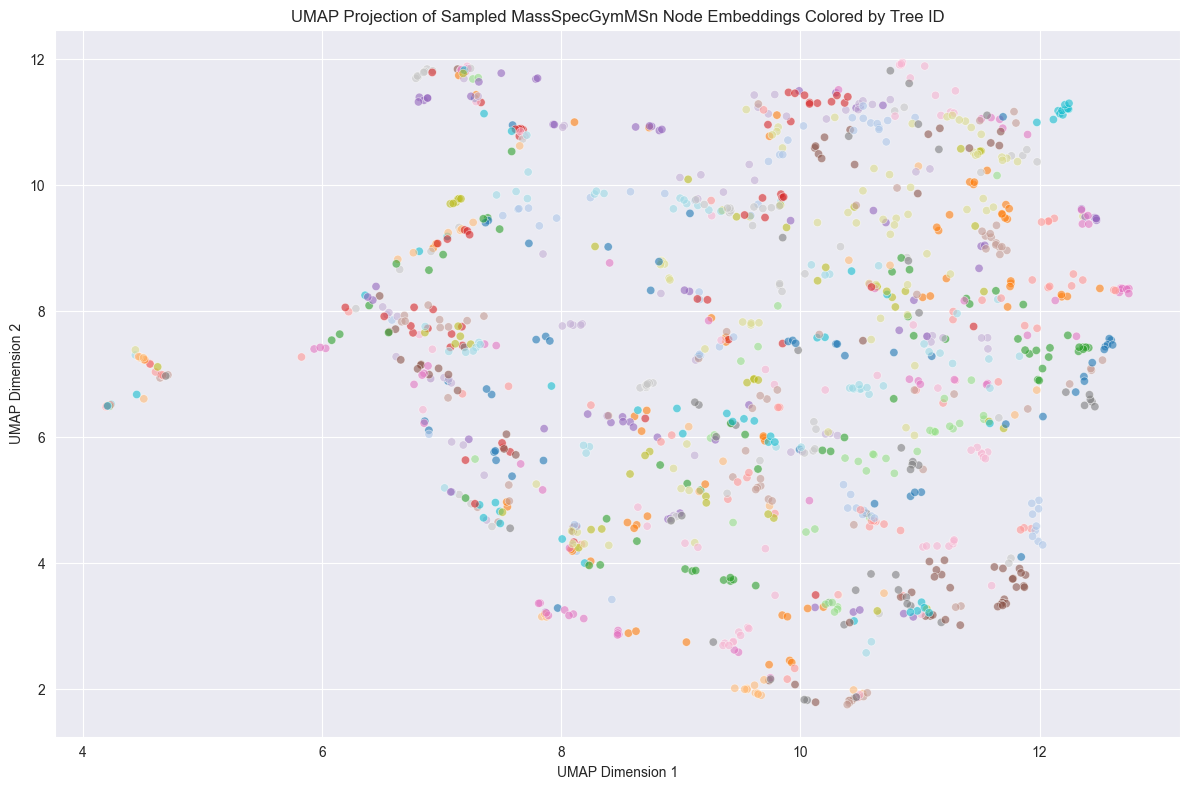

In [61]:
plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", num_trees_to_sample)  # Unique colors for each tree

sns.scatterplot(
    x='UMAP_1',
    y='UMAP_2',
    hue='tree_id',
    palette='tab20',  # Limited to 20 distinct colors; adjust if necessary
    data=data_sampled_visual,
    legend=False,
    alpha=0.6
)
plt.title('UMAP Projection of Sampled MassSpecGymMSn Node Embeddings Colored by Tree ID')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.tight_layout()
plt.show()